In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler

ERROR 1: PROJ: proj_create_from_database: Open of /storage/homefs/hb22g102/mambaforge/envs/env11/share/proj failed


In [2]:
exp = MultiVarExperiment("ERA5", "plev", ["u", "v", "s"], "6H", "all", None, -80, 30, 20, 80, [150, 200, 250, 300, 350])
all_jets, where_are_jets, all_jets_one_array, all_jets_over_time, flags = exp.track_jets()
props_as_ds_uncat = exp.props_as_ds(False)
props_as_ds = exp.props_as_ds(True)
props_as_ds["nao"] = get_nao(props_as_ds)
jet_pos_da = jet_position_as_da(exp.ds["s"], props_as_ds, props_as_ds_uncat, all_jets, exp.path)
overlap = (jet_pos_da > 0).any("lat").all("jet")
props_as_ds["double_jet_index"] = overlap.sel(lon=slice(-20, None, None)).mean("lon")

# DST

In [3]:
from CDSK import dynamical_local_indexes

In [4]:
subset = ["mean_lon", "mean_lat", "Spe", "mean_lev", "width", "tilt", "sinuosity", "int", "com_speed"]
jets = props_as_ds.jet.values

In [8]:
X = []
full_varname = []
time_mask1 = props_as_ds.time.dt.year >= 1959
time_mask2 = props_as_ds.time.dt.season == "JJA"
time_mask = time_mask1 & time_mask2
for varname, jet in product(subset, jets):
    if varname == "Lat":
        default_value = 50 if jet == "polar" else 30
    else:
        default_value = 1
    X.append(np.nan_to_num(props_as_ds[varname].sel(jet=jet, time=time_mask).values, nan=default_value))
    full_varname.append(f"{varname}_{jet}")
X = np.vstack(X).T.copy()

In [9]:
ld, theta, _ = dynamical_local_indexes(X[:, :, None], ql=0.98, ld_fit="SDFC", n_jobs=10)

100%|██████████| 23552/23552 [00:00<00:00, 27011.92it/s]


In [26]:
np.save("results/tmp/ld.npy", ld.ravel())
np.save("results/tmp/theta.npy", theta.ravel())

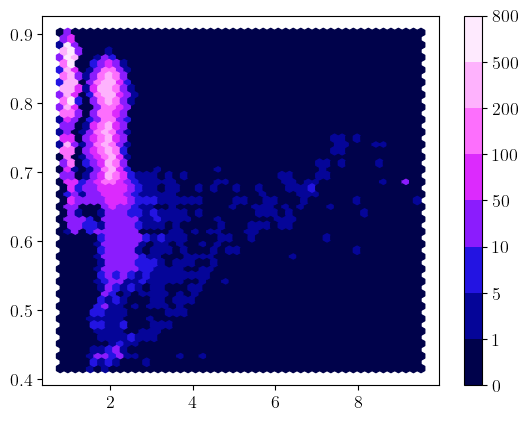

In [23]:
ld_ = ld[:, 0, 0]
ld_[ld_ > 1e7] = 0
cmap = colormaps.cet_l_bmw
norm = BoundaryNorm([0, 1, 5, 10, 50, 100, 200, 500, 800], cmap.N)
im = plt.hexbin(ld_, theta.ravel(), cmap=cmap, norm=norm, gridsize=48)
plt.colorbar(im)
# plt.plot(ld_, theta.ravel(), "wx")

# Trends

## Summer

In [4]:
data_vars = ["mean_lon", "mean_lat", "mean_lev", "Spe", "tilt", "waviness", "width", "int", "int_over_europe", "persistence", "com_speed", "double_jet_index"]
def plot_trends_full(data_vars: list, props_as_ds: xr.Dataset, season: str | None = None, std: bool = False):
    fig, axes = plt.subplots(3, 4, figsize=(20, 10), tight_layout=True, sharex="all")
    axes = axes.flatten()
    if season is not None:
        month_list = SEASONS[season]
        season_mask = np.isin(props_as_ds.time.dt.month.values, month_list)
        props_as_ds = props_as_ds.sel(time=season_mask)
    else:
        season = "all_year"
    if std:
        props_as_ds = props_as_ds.resample(time="1YE").std()
    else:
        props_as_ds = props_as_ds.resample(time="1YE").mean()
    x = props_as_ds.time.dt.year.values
    for i, (varname, ax) in enumerate(zip(data_vars, axes)):
        if varname == "mean_lev":
            ax.invert_yaxis()
        for j, jet in enumerate(["subtropical", "polar"]):
            try:
                ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]")
            except KeyError:
                ax.set_title(varname)
            try:
                this_da = props_as_ds[varname].sel(jet=jet)
                ax.plot(x, this_da.values, lw=3, color=COLORS[2 - j])
                c1, c0, _, p, _ = linregress(x, this_da.values)
                if p < 0.05:
                    ls = "dashed"
                else:
                    ls = "dotted"
                ax.plot(
                    x,
                    c1 * x + c0,
                    lw=2.5,
                    color=COLORS[2 - j],
                    ls=ls,
                    label=f"{jet}, {p_to_tex(c1, c0)}, $p={p:.2f}$",
                )
            except KeyError:
                this_da = props_as_ds[varname]
                ax.plot(x, this_da.values, lw=3, color="black")
                c1, c0, _, p, _ = linregress(x, this_da.values)
                if p < 0.05:
                    ls = "dashed"
                else:
                    ls = "dotted"
                ax.plot(x, c1 * x + c0, lw=2.5, color="black", ls=ls, label=f"{p_to_tex(c1, c0)}, $p={p:.2f}$")
                break
        ax.legend(ncol=1, fontsize=10)
    subtitle = "std" if std else "trends"
    fig.savefig(f"{FIGURES}/jet_props_trends/jet_props_{subtitle}_{season}.png", **SAVE_KWARGS)

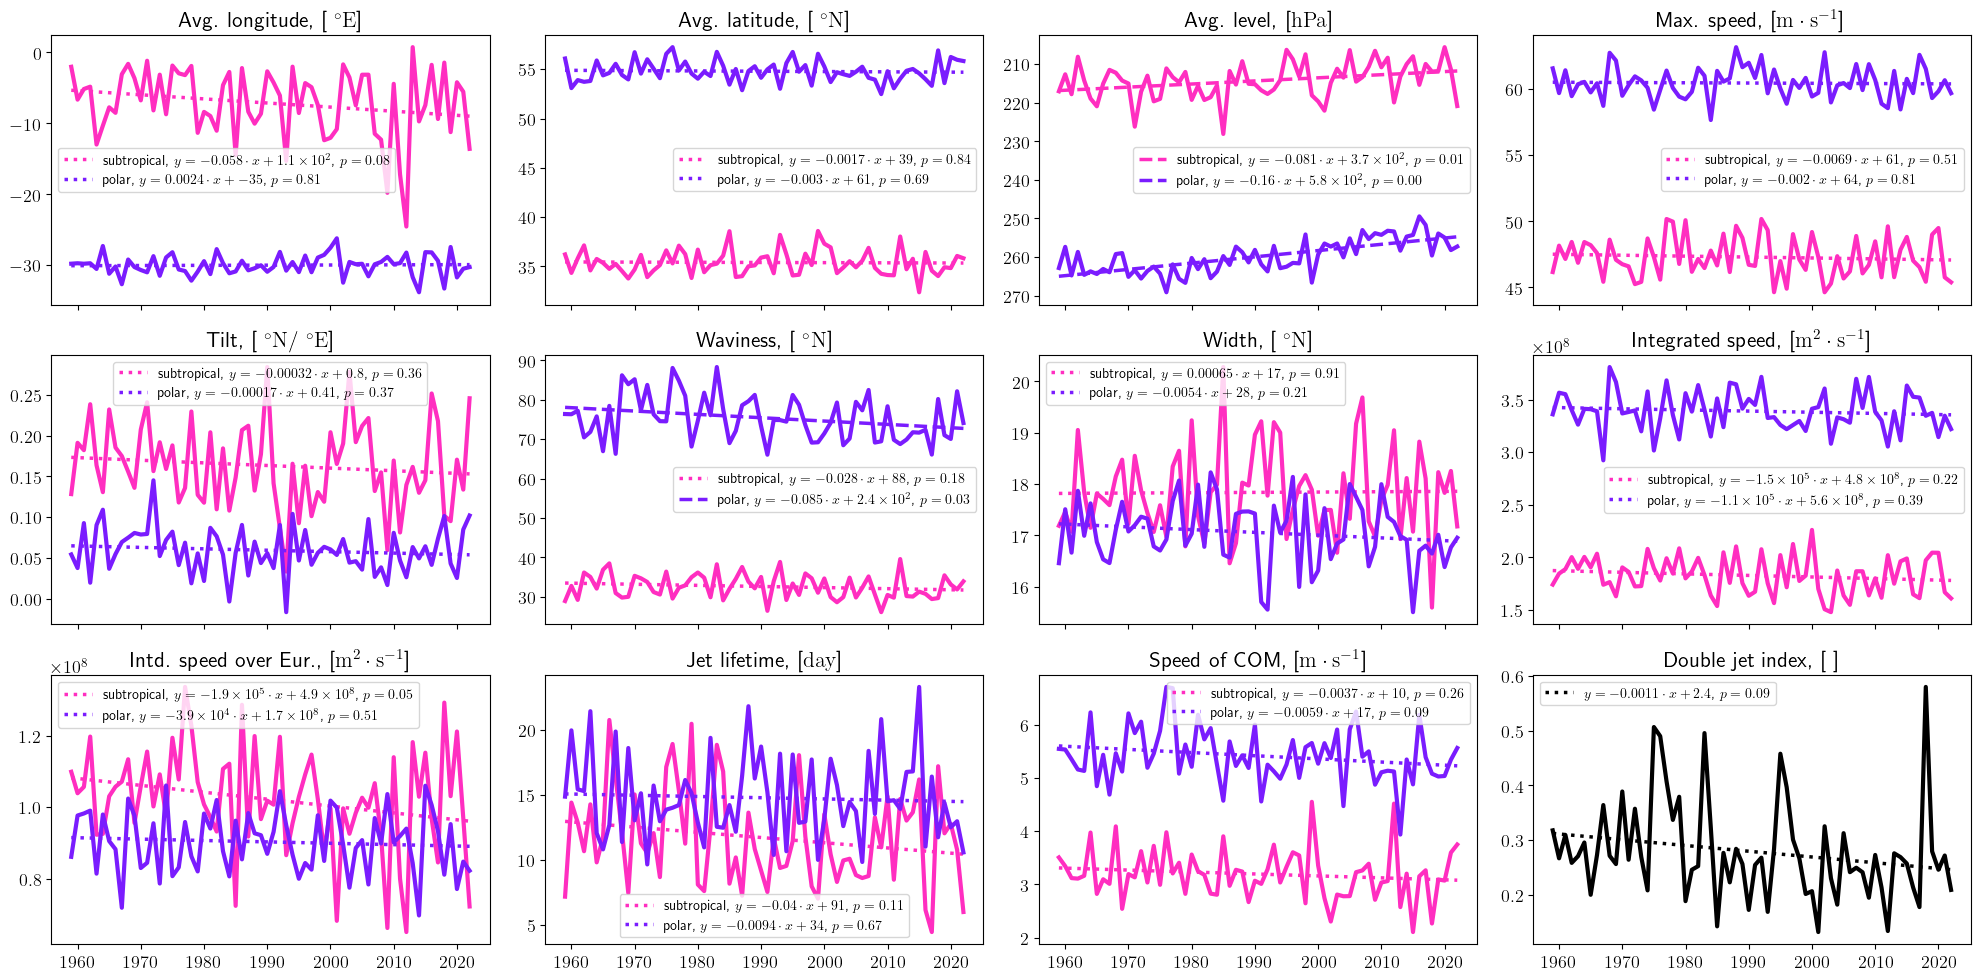

In [15]:
plot_trends_full(data_vars, props_as_ds, "JJA")

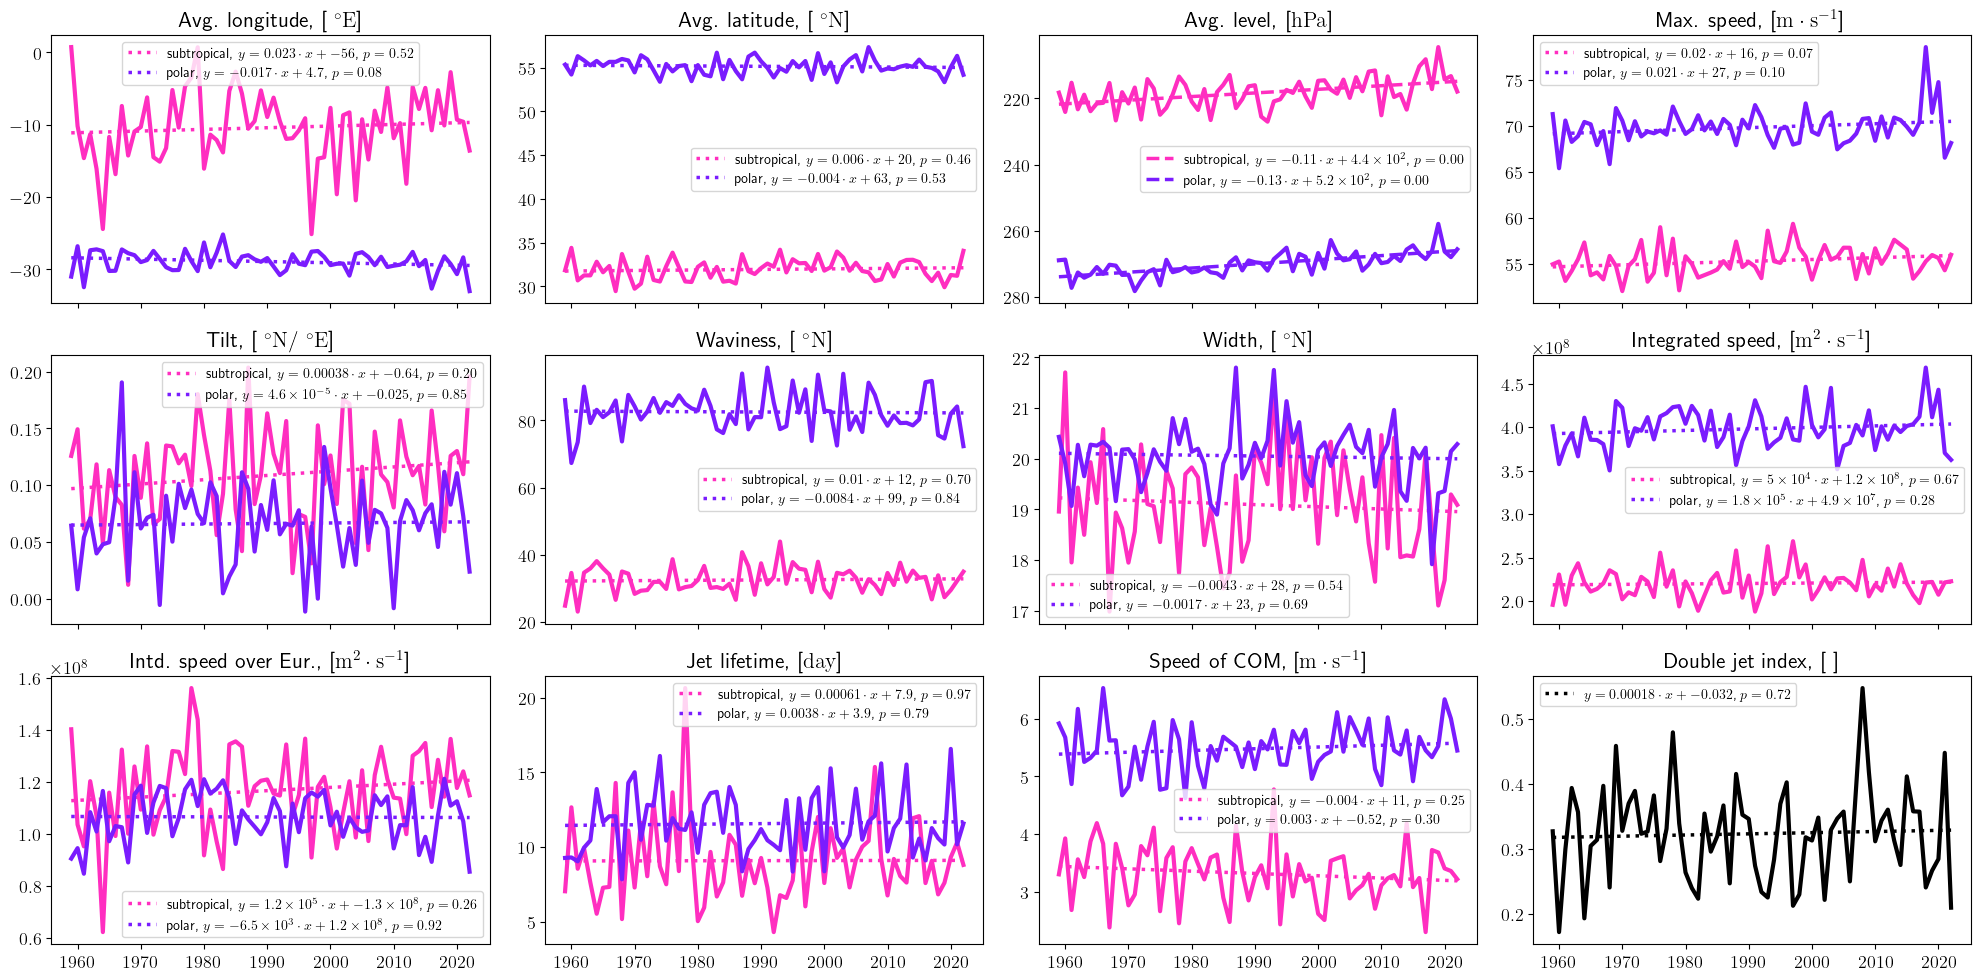

In [17]:
plot_trends_full(data_vars, props_as_ds, "SON")

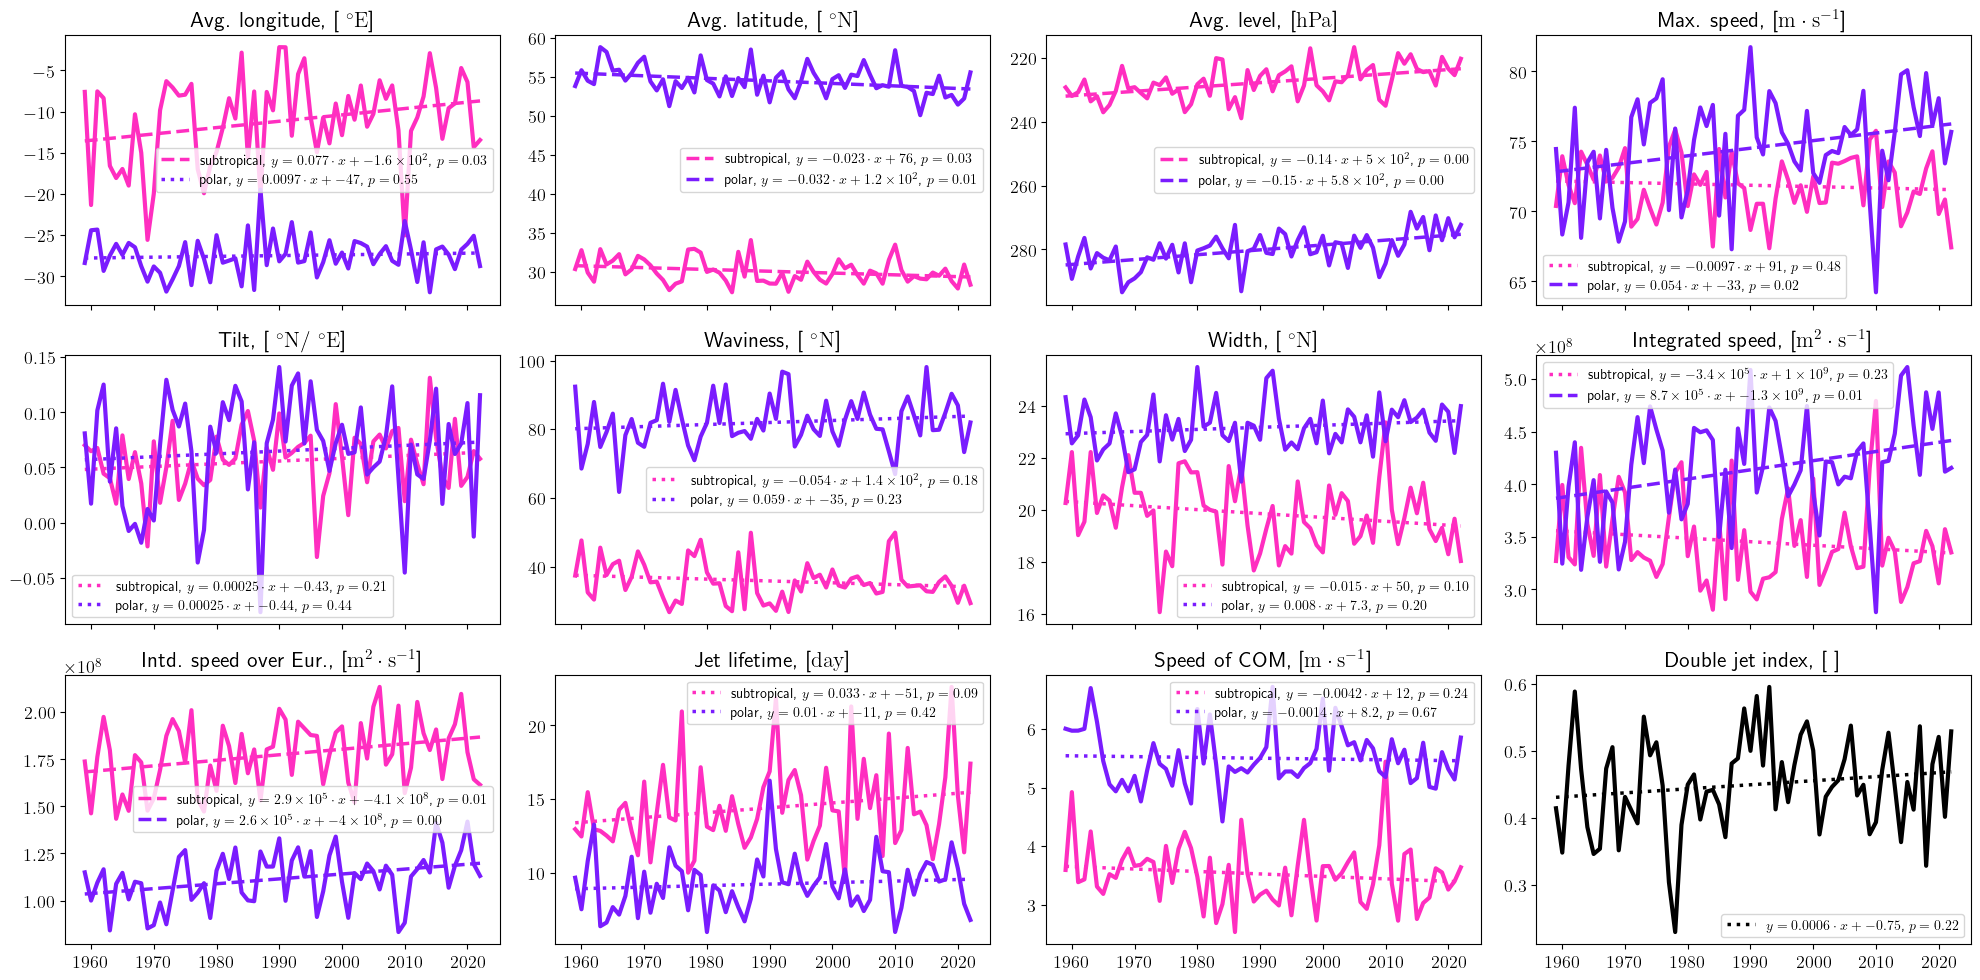

In [18]:
plot_trends_full(data_vars, props_as_ds, "DJF")

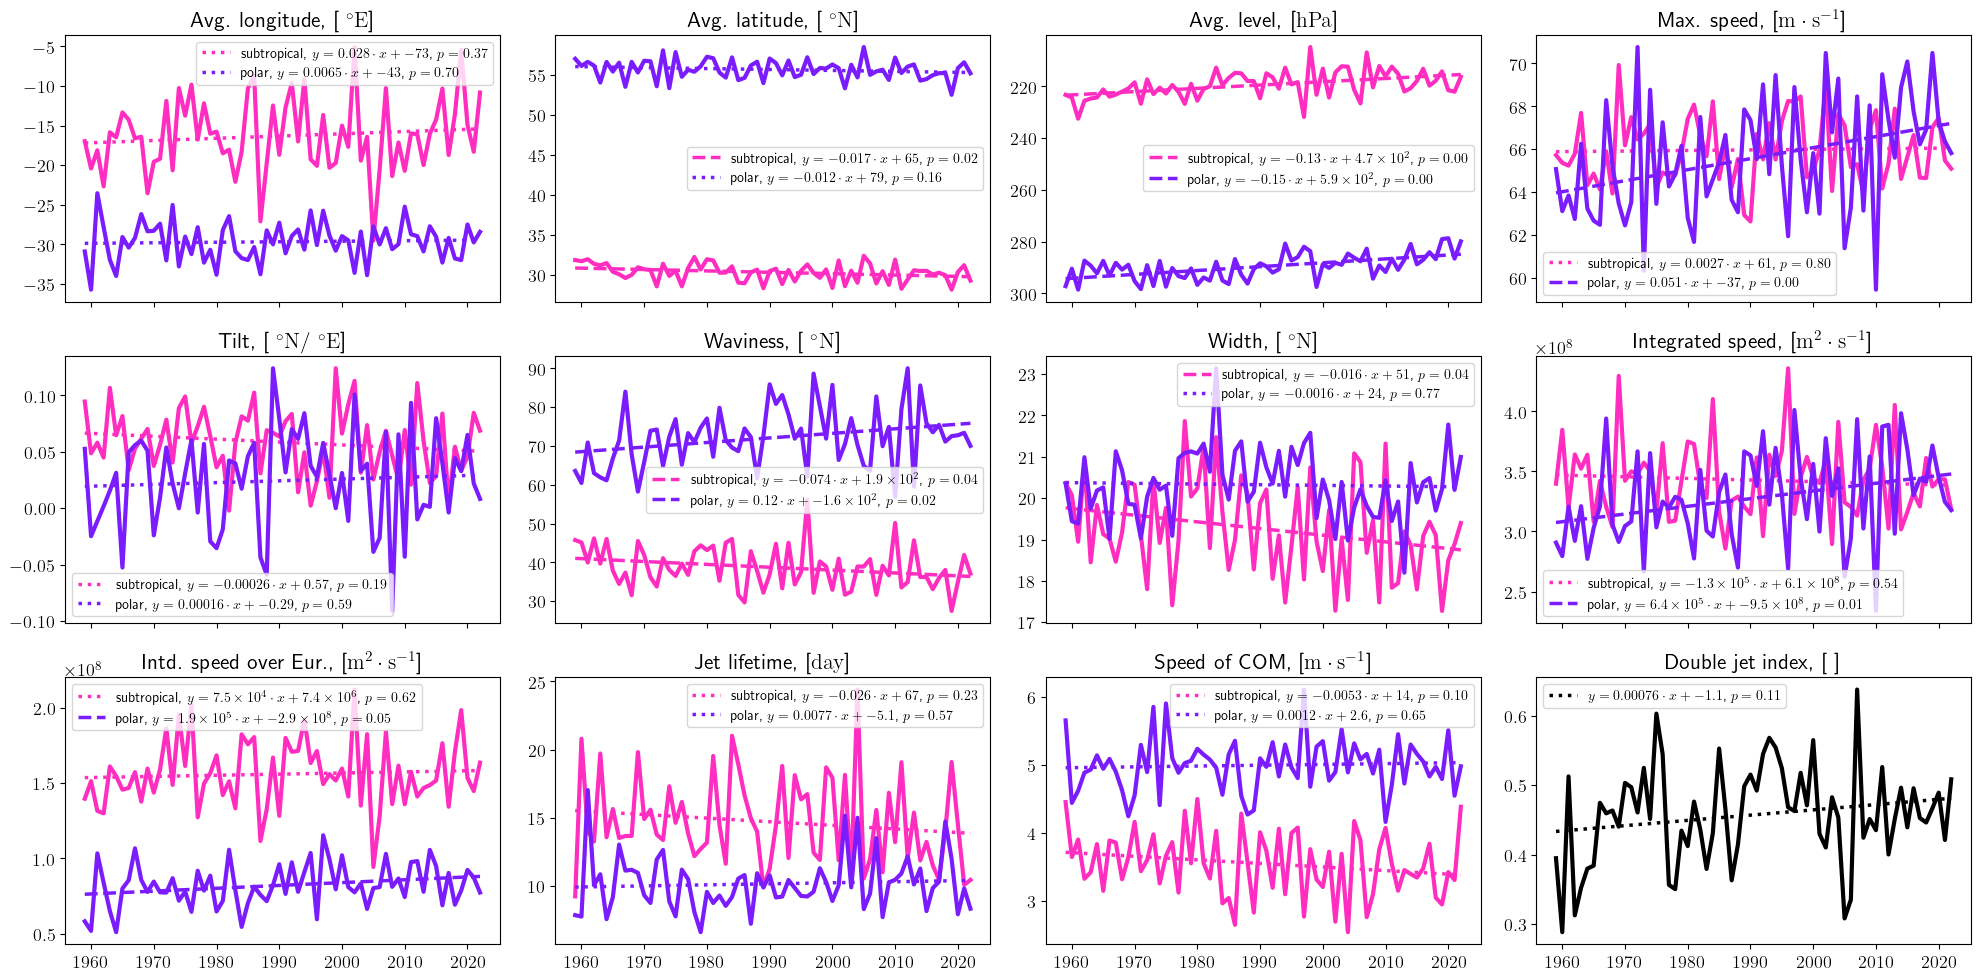

In [19]:
plot_trends_full(data_vars, props_as_ds, "MAM")

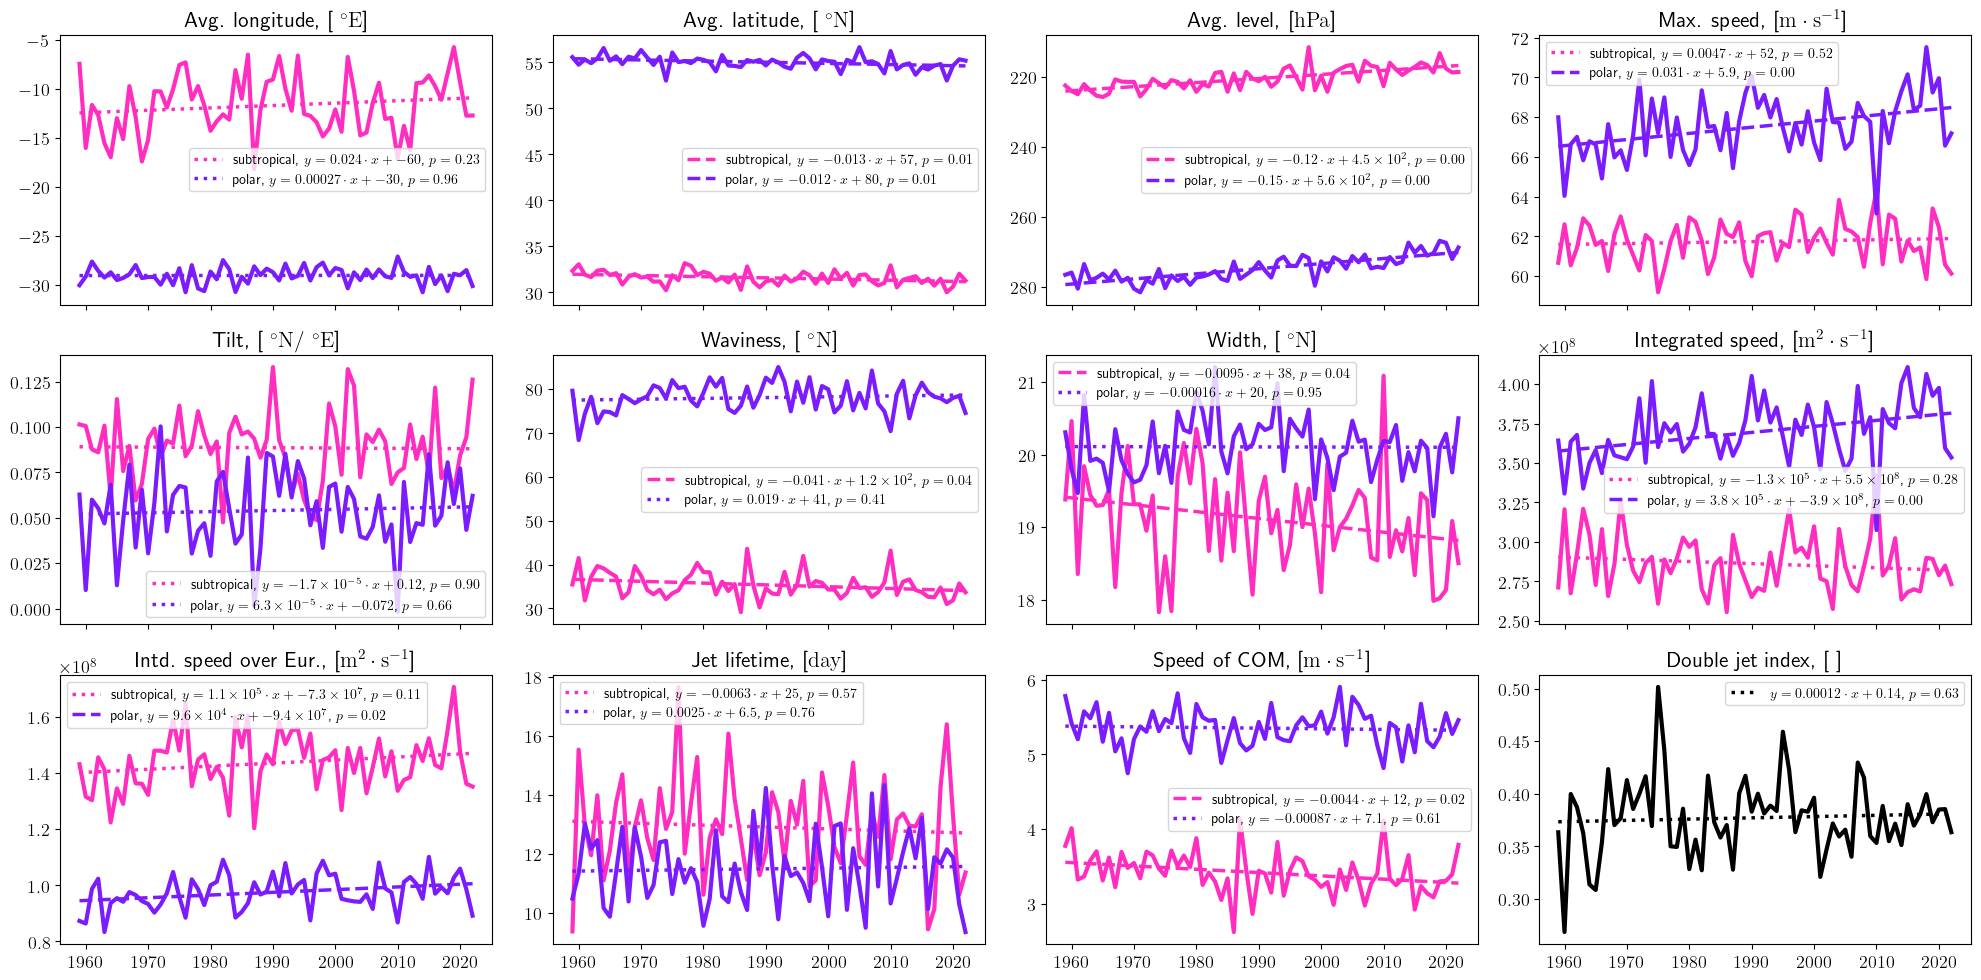

In [20]:
plot_trends_full(data_vars, props_as_ds, None)

# Trends in Variability

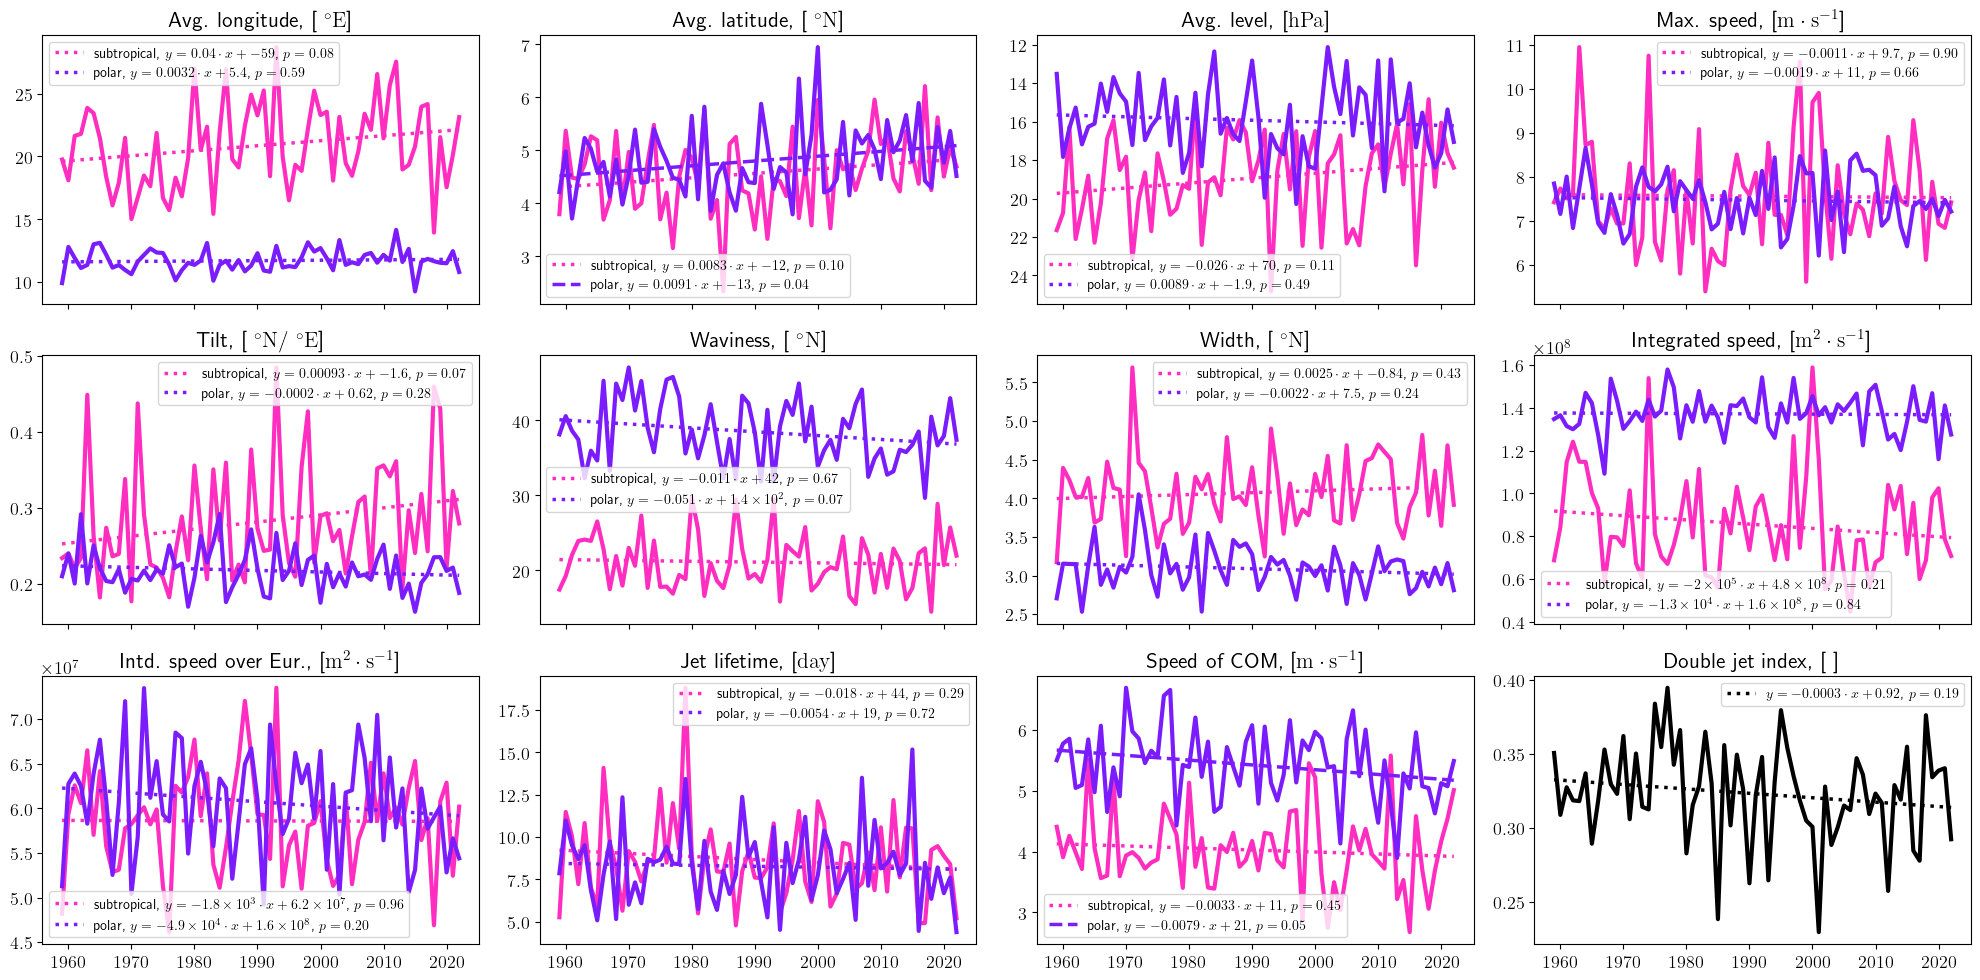

In [22]:
plot_trends_full(data_vars, props_as_ds, "JJA", True)

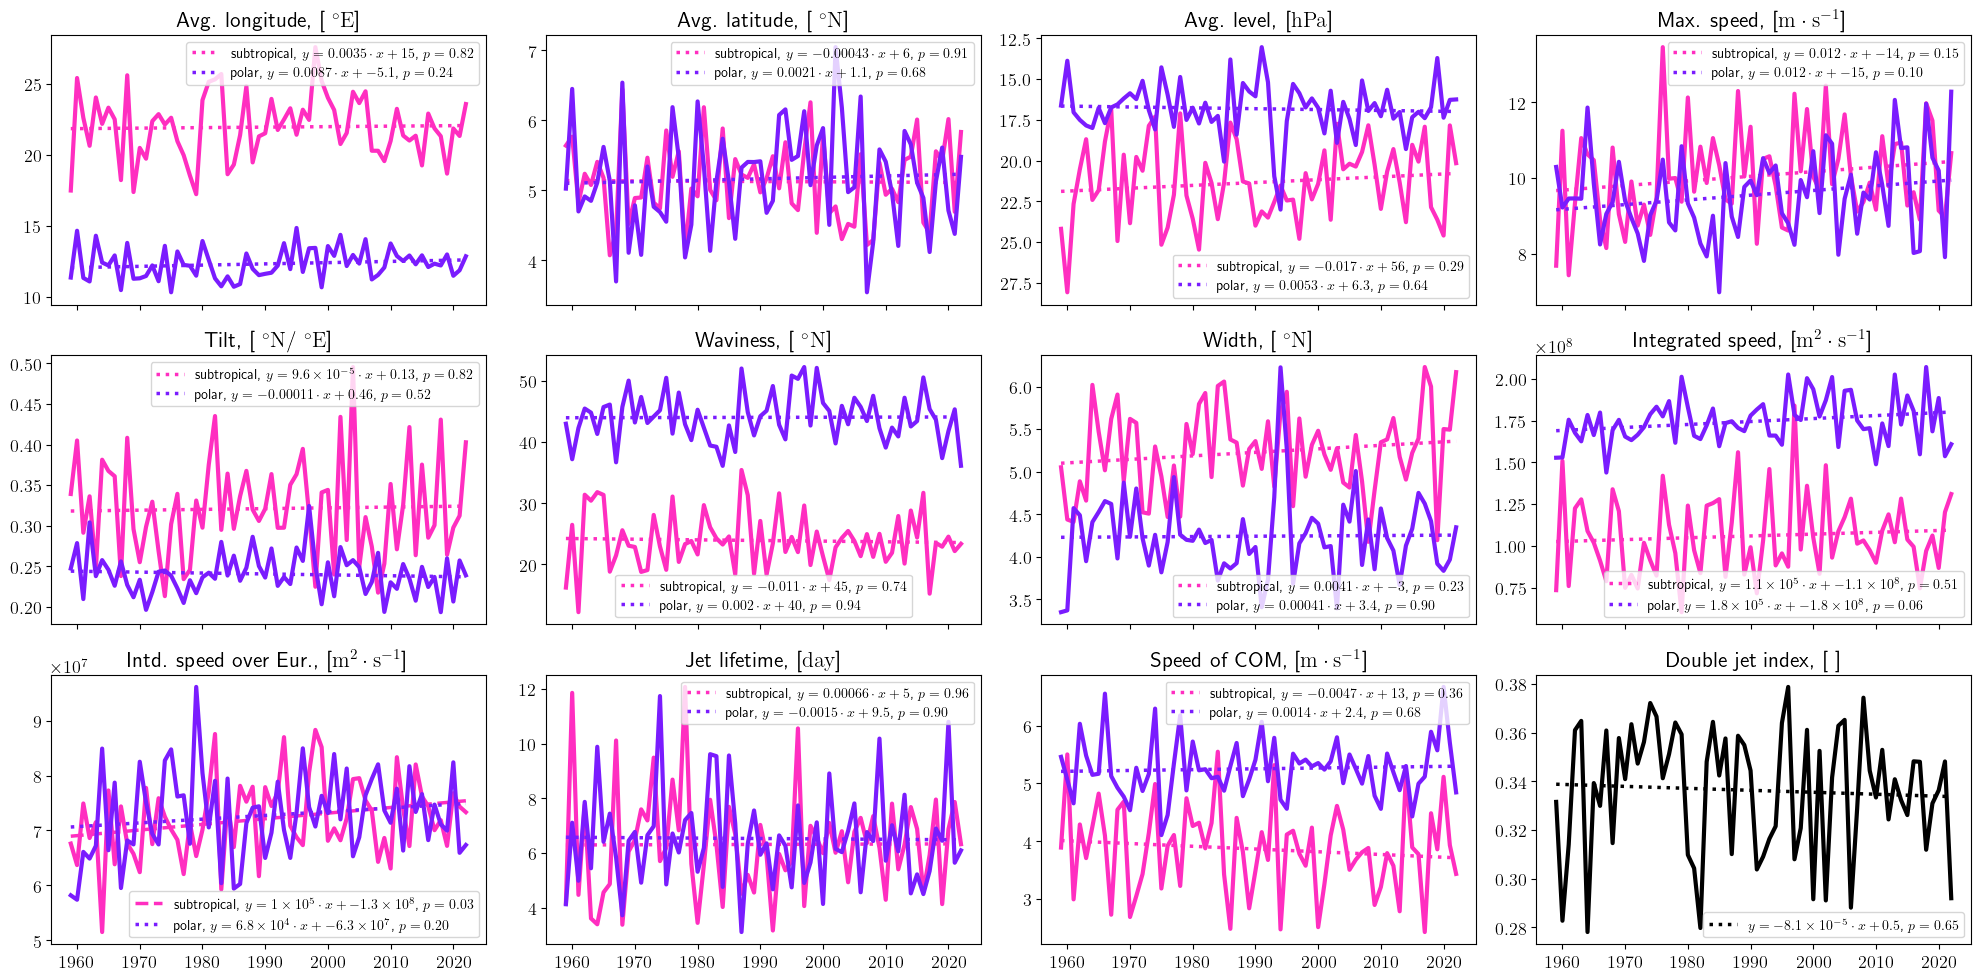

In [23]:
plot_trends_full(data_vars, props_as_ds, "SON", True)

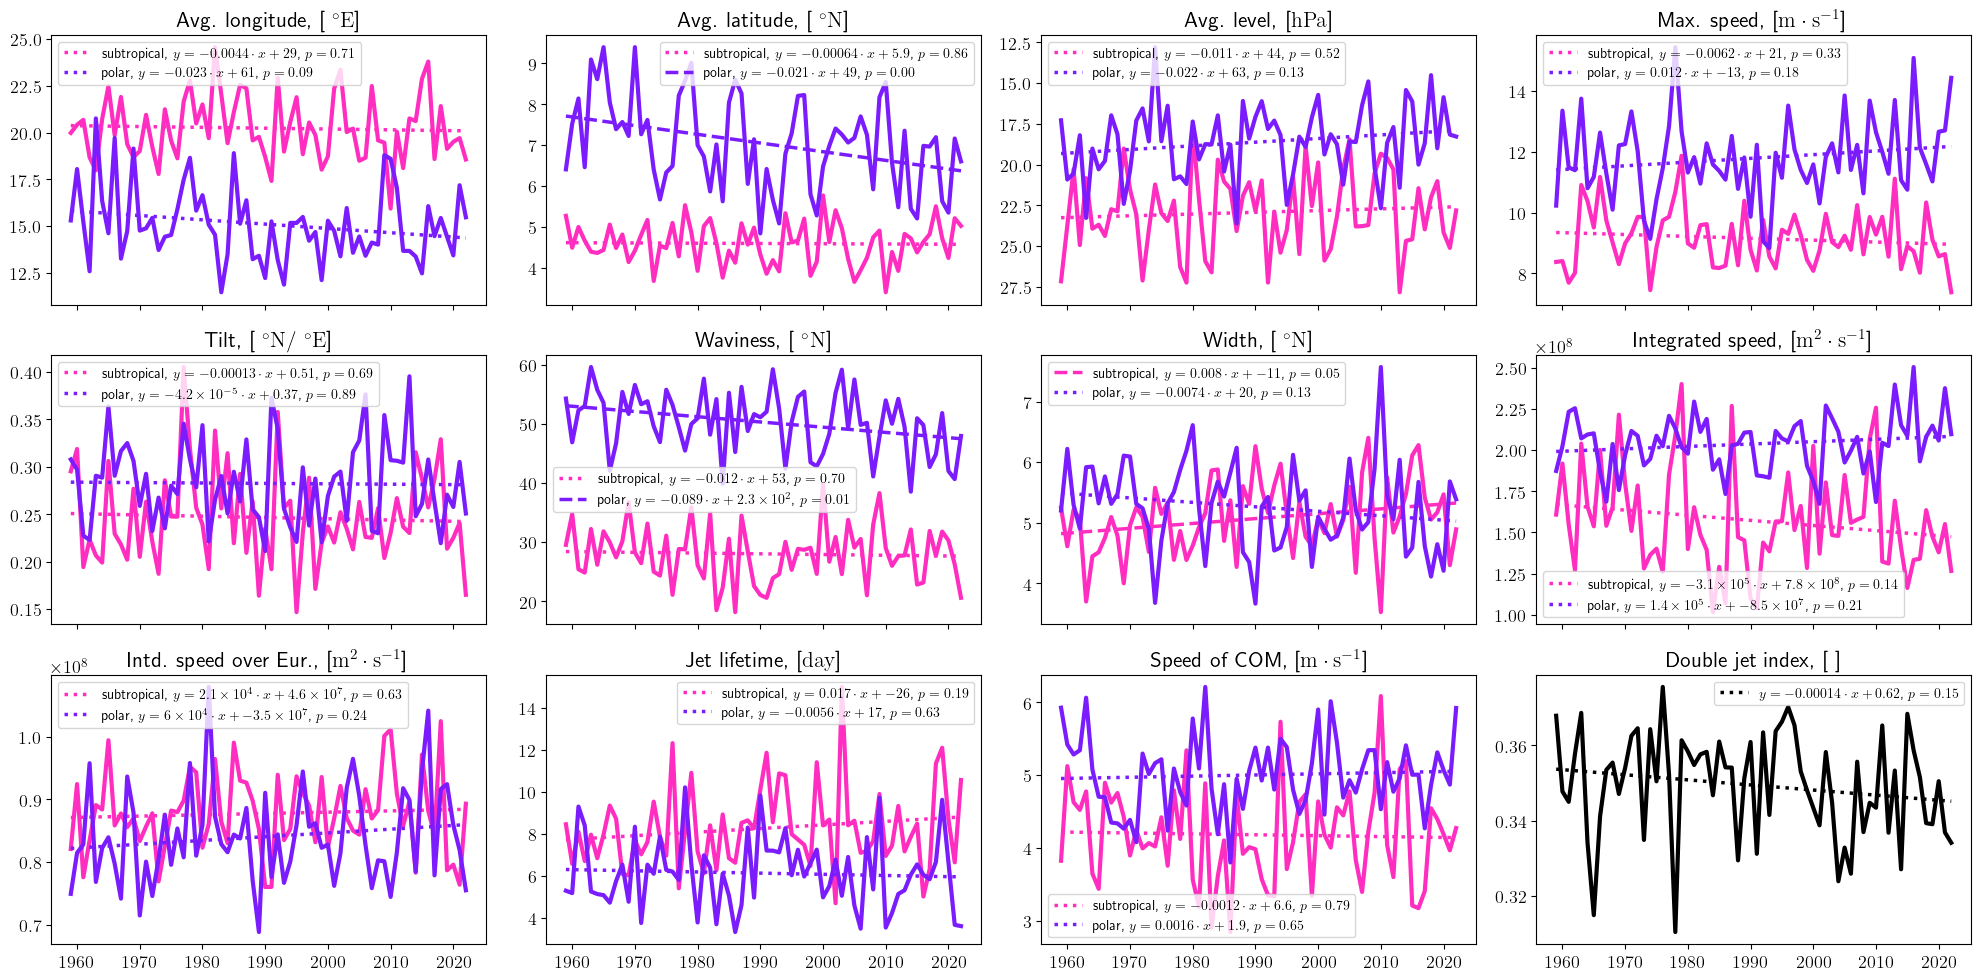

In [24]:
plot_trends_full(data_vars, props_as_ds, "DJF", True)

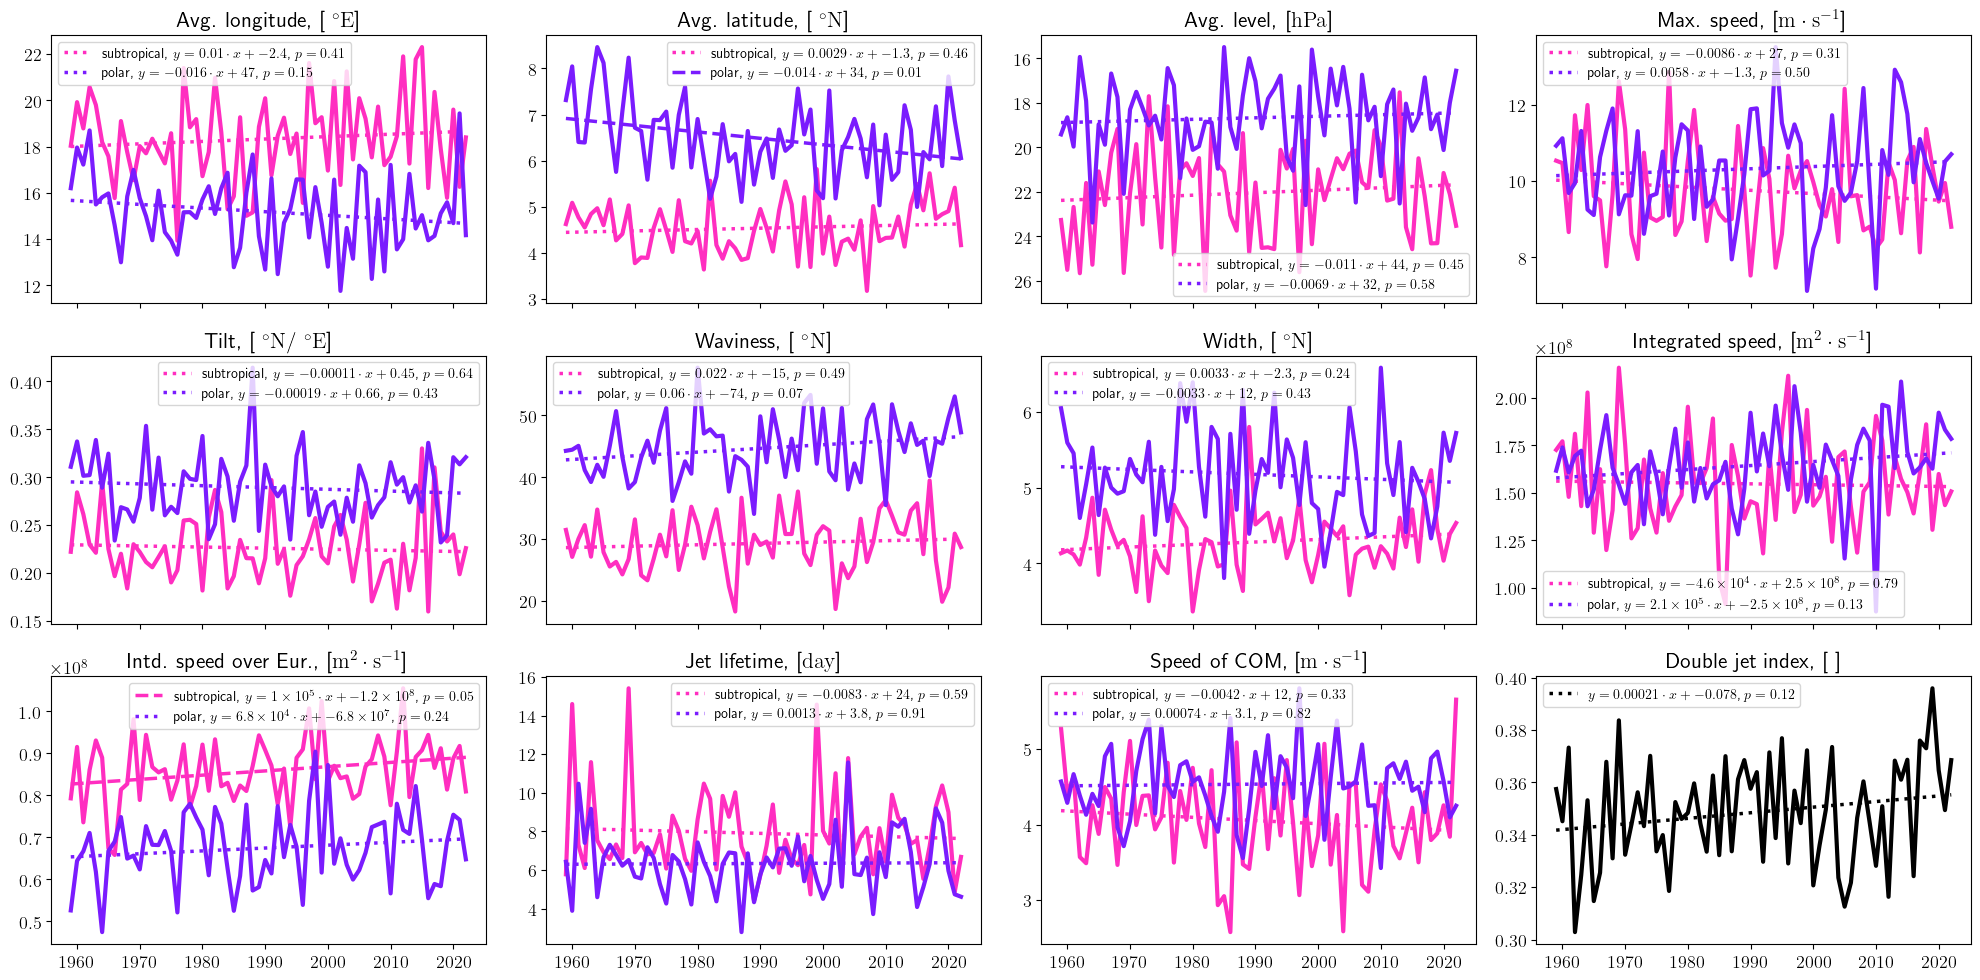

In [25]:
plot_trends_full(data_vars, props_as_ds, "MAM", True)

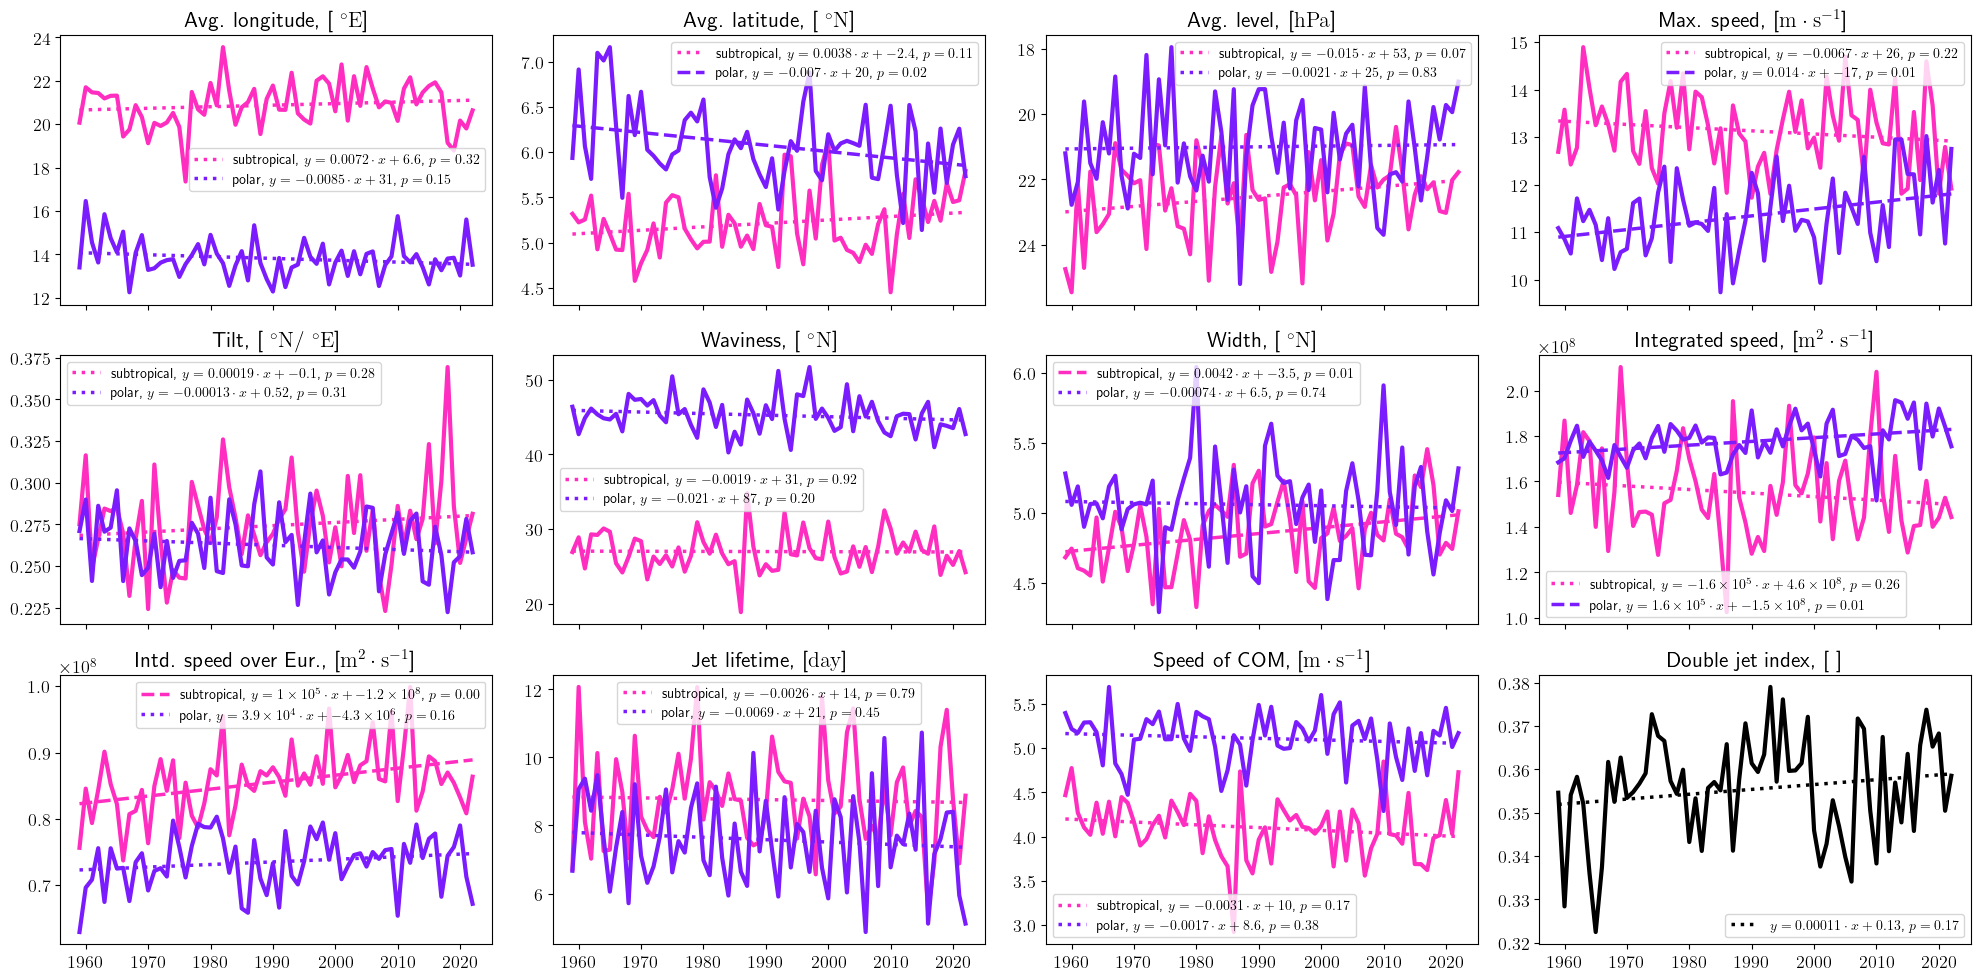

In [26]:
plot_trends_full(data_vars, props_as_ds, None, True)

# Correlations

In [48]:
da_pvs = Experiment("ERA5", "surf", "pvs", "6H", "all", "JJA", *exp.region, 250, "hourofyear", {"hourofyear": ("win", 60)}).da.reset_coords("lev", drop=True)

In [49]:
season_mask = (props_as_ds.time.dt.season == "JJA")
props_as_ds_late = props_as_ds.sel(time=season_mask)
props_as_ds_late["anti_pv_activity"] = da_pvs.sel(type="anti").sum(dim=["lon", "lat"])
props_as_ds_late["cycl_pv_activity"] = da_pvs.sel(type="cycl").sum(dim=["lon", "lat"])
cmap = colormaps.BlWhRe
norm = BoundaryNorm(np.delete(np.arange(-1, 1.1, 0.2), 5), cmap.N)

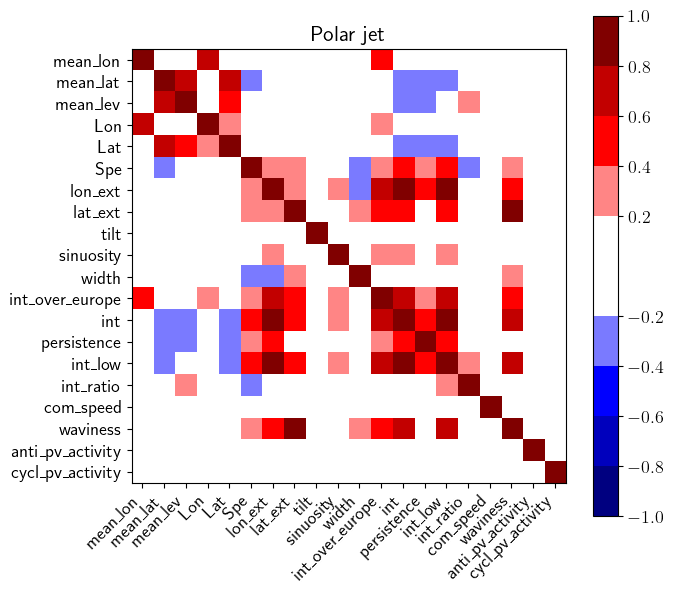

In [50]:
to_concat = []
polar_valids = ~props_as_ds_late["mean_lon"].sel(jet="polar").isnull().values
for varname, da in props_as_ds_late.items():
    if varname not in [
        "anti_pv_activity",
        "cycl_pv_activity",
        "overlap",
        "vert_dist",
        "n_jets",
        "nao",
        "double_jet_index",
    ]:
        to_concat.append(da.sel(jet="polar").fillna(DEFAULT_VALUES.get(varname, 0)).values[polar_valids])
    else:
        to_concat.append(da.fillna(0).values[polar_valids])
fig, ax = plt.subplots(figsize=(7, 6.5))
im = plt.imshow(np.corrcoef(np.stack(to_concat)), cmap=cmap, norm=norm)
plt.colorbar(im, spacing="proportional")
ax.set_yticks(np.arange(0, len(props_as_ds_late.data_vars)), props_as_ds_late.data_vars)
_ = ax.set_xticks(
    np.arange(0, len(props_as_ds_late.data_vars)),
    props_as_ds_late.data_vars,
    rotation=45,
    ha="right",
)
ax.set_title("Polar jet")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_polar.png", **SAVE_KWARGS)

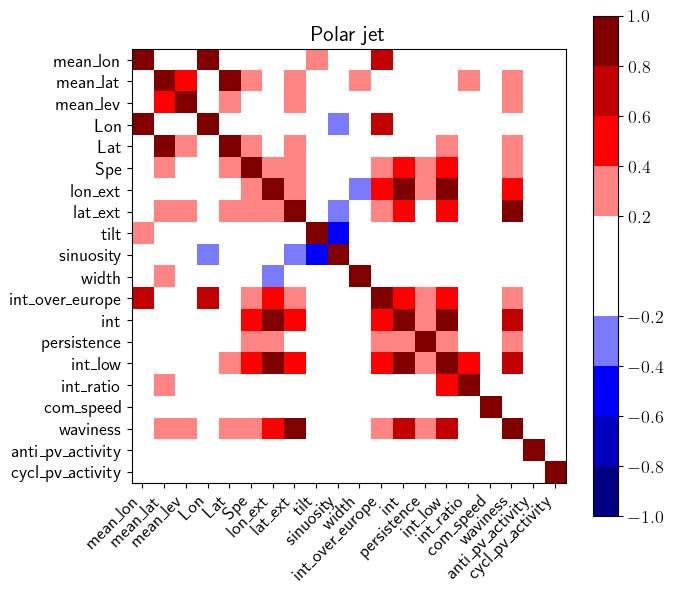

In [51]:
to_concat = []
polar_valids = ~props_as_ds_late["mean_lon"].sel(jet="subtropical").isnull().values
for varname, da in props_as_ds_late.items():
    if varname not in [
        "anti_pv_activity",
        "cycl_pv_activity",
        "overlap",
        "vert_dist",
        "n_jets",
        "nao",
        "double_jet_index"
    ]:
        to_concat.append(da.sel(jet="subtropical").fillna(DEFAULT_VALUES.get(varname, 0)).values[polar_valids])
    else:
        to_concat.append(da.fillna(0).values[polar_valids])
fig, ax = plt.subplots(figsize=(7, 6.5))
im = plt.imshow(np.corrcoef(np.stack(to_concat)), cmap=cmap, norm=norm)
plt.colorbar(im, spacing="proportional")
ax.set_yticks(np.arange(0, len(props_as_ds_late.data_vars)), props_as_ds_late.data_vars)
_ = ax.set_xticks(
    np.arange(0, len(props_as_ds_late.data_vars)),
    props_as_ds_late.data_vars,
    rotation=45,
    ha="right",
)
ax.set_title("Polar jet")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_subtropical.png", **SAVE_KWARGS)

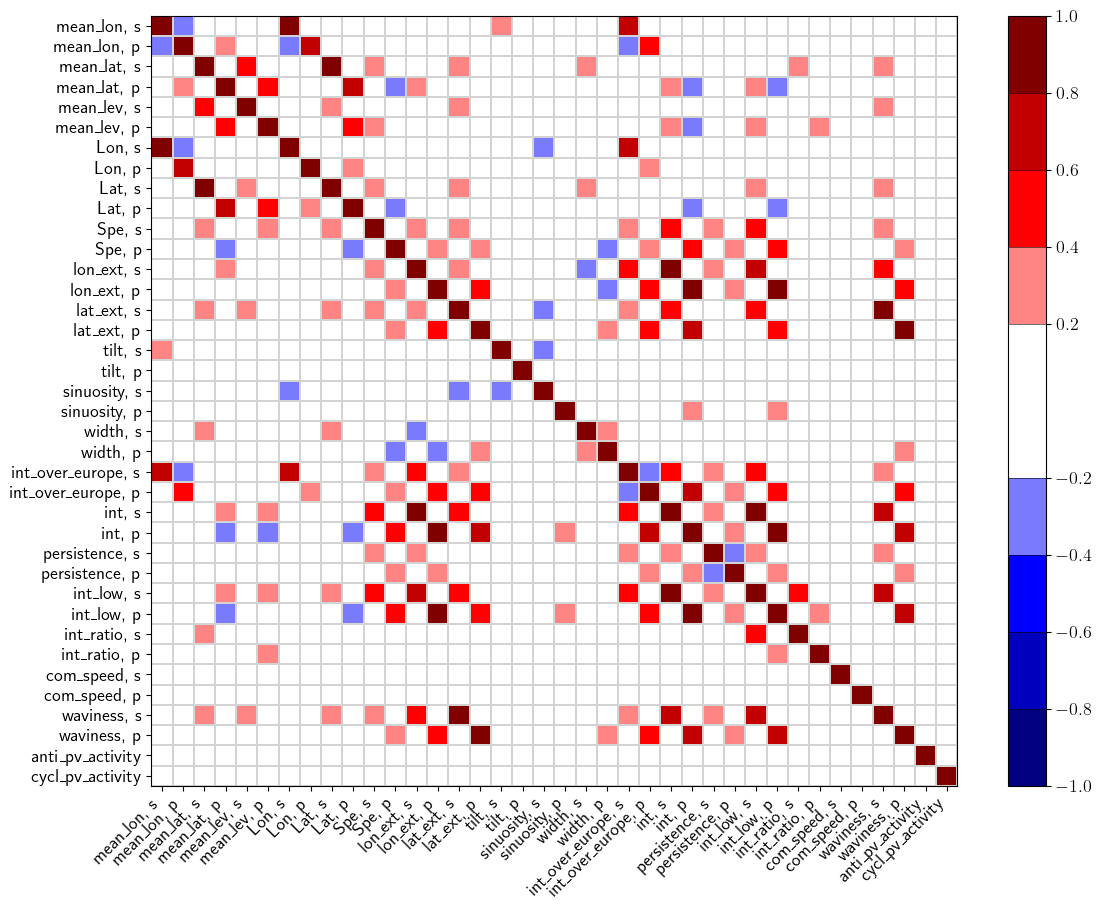

In [52]:
to_concat = []
ticks = []
valids = props_as_ds_late["mean_lon"]
valids = (
    ~valids.sel(jet="polar").isnull() & ~valids.sel(jet="subtropical").isnull()
).values
for varname, da in props_as_ds_late.items():
    if varname not in [
        "anti_pv_activity",
        "cycl_pv_activity",
        "overlap",
        "vert_dist",
        "n_jets",
        "nao",
        "double_jet_index",
    ]:
        for jet in da.jet.values:
            to_concat.append(da.sel(jet=jet).fillna(DEFAULT_VALUES.get(varname, 0)).values[valids])
            ticks.append(f"{varname}, {jet[0]}")
    else:
        to_concat.append(np.roll(da.fillna(0).values[valids], 0))
        ticks.append(varname)
fig, ax = plt.subplots(figsize=(13, 10))
im = plt.pcolormesh(np.corrcoef(np.stack(to_concat)), cmap=cmap, norm=norm, lw=0.01, edgecolors="lightgrey")
plt.colorbar(im, spacing="proportional", drawedges=True)
ax.invert_yaxis()
ax.set_yticks(np.arange(0.5, len(ticks) + 0.5), ticks)
_ = ax.set_xticks(np.arange(0.5, len(ticks) + 0.5), ticks, rotation=45, ha="right")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_full.png", **SAVE_KWARGS)

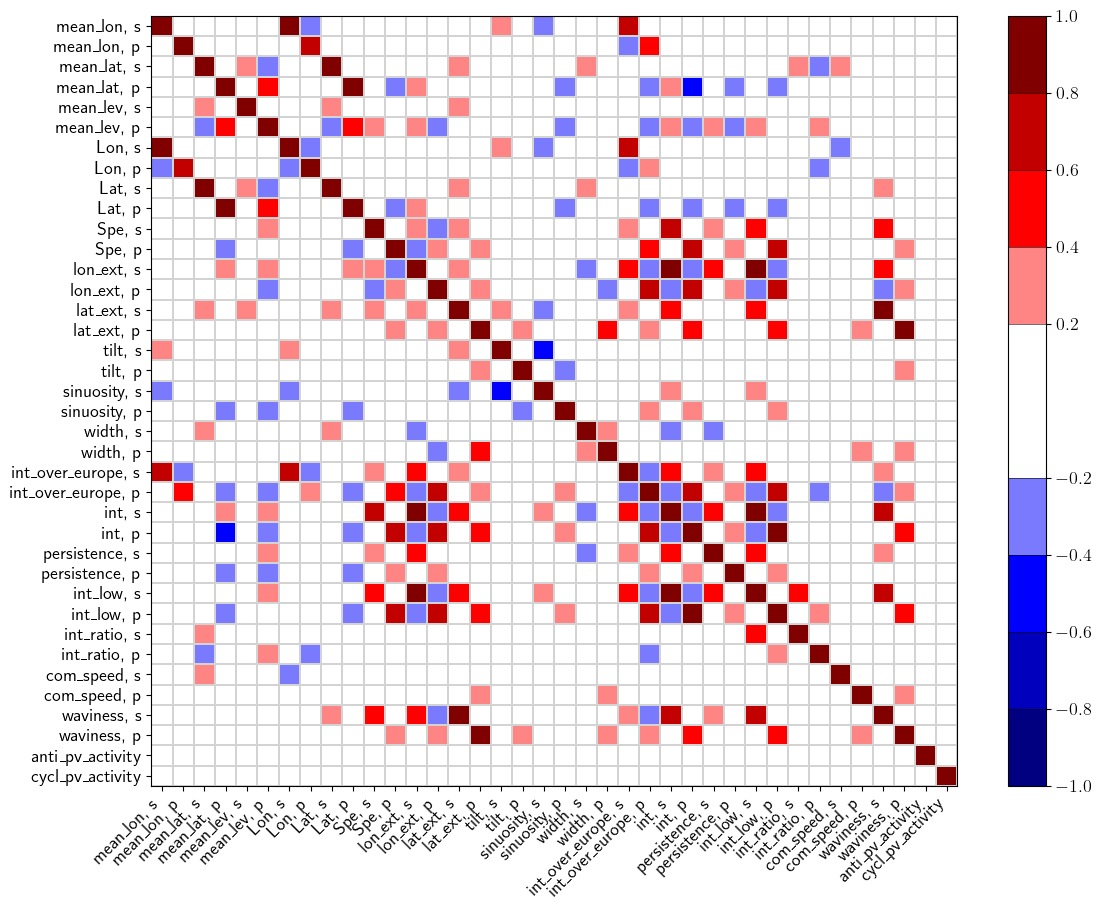

In [53]:
to_concat = []
ticks = []
freq = "1W"
this_pads = props_as_ds_late.resample(time=freq).mean()
valids = this_pads["mean_lon"]
valids = (
    ~valids.sel(jet="polar").isnull() & ~valids.sel(jet="subtropical").isnull()
).values
for varname, da in this_pads.items():
    if varname not in [
        "anti_pv_activity",
        "cycl_pv_activity",
        "overlap",
        "vert_dist",
        "n_jets",
        "nao",
        "double_jet_index",
    ]:
        for jet in da.jet.values:
            to_concat.append(da.sel(jet=jet).fillna(DEFAULT_VALUES.get(varname, 0)).values[valids])
            ticks.append(f"{varname}, {jet[0]}")
    else:
        to_concat.append(np.roll(da.fillna(0).values[valids], 0))
        ticks.append(varname)
fig, ax = plt.subplots(figsize=(13, 10))
im = plt.pcolormesh(np.corrcoef(np.stack(to_concat)), cmap=cmap, norm=norm, lw=0.01, edgecolors="lightgrey")
plt.colorbar(im, spacing="proportional", drawedges=True)
ax.invert_yaxis()
ax.set_yticks(np.arange(0.5, len(ticks) + 0.5), ticks)
_ = ax.set_xticks(np.arange(0.5, len(ticks) + 0.5), ticks, rotation=45, ha="right")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_full_{freq}.png", **SAVE_KWARGS)

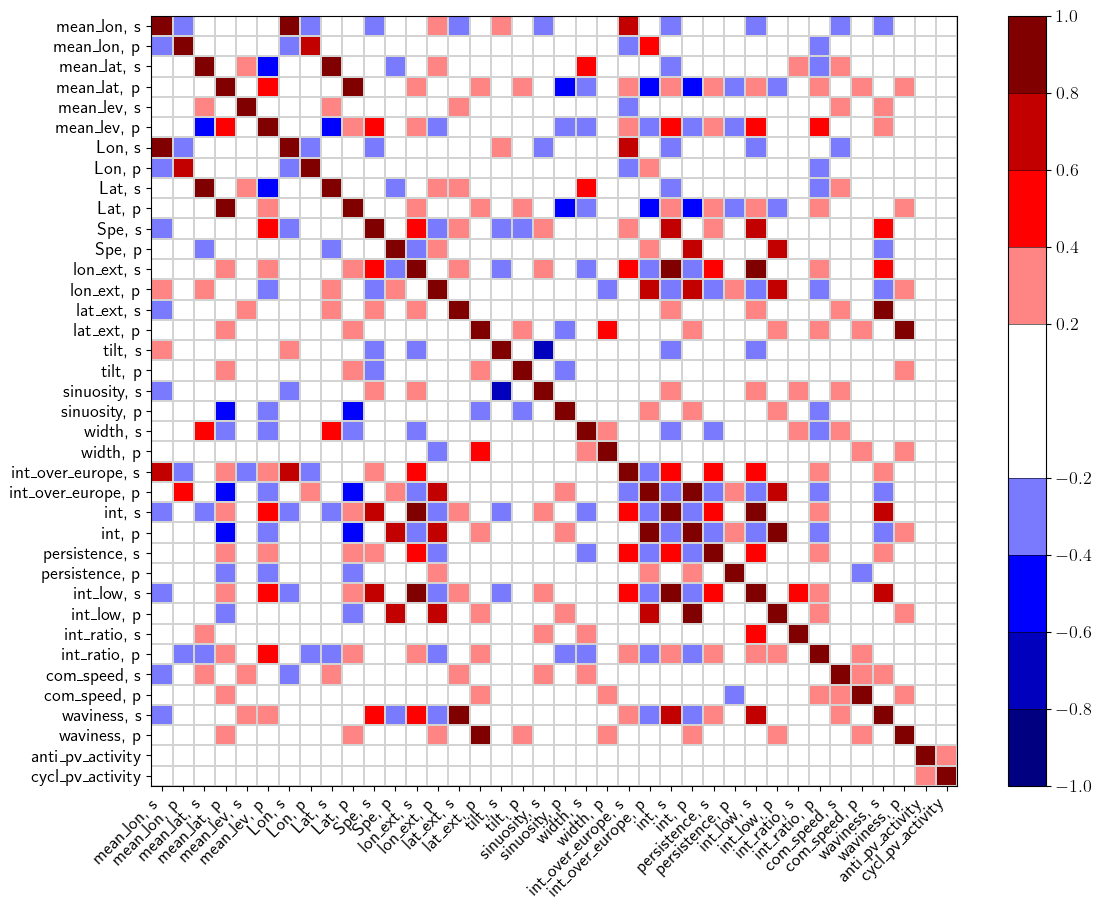

In [54]:
to_concat = []
ticks = []
freq = "1ME"
this_pads = props_as_ds_late.resample(time=freq).mean()
valids = this_pads["mean_lon"]
valids = (
    ~valids.sel(jet="polar").isnull() & ~valids.sel(jet="subtropical").isnull()
).values
for varname, da in this_pads.items():
    if varname not in [
        "anti_pv_activity",
        "cycl_pv_activity",
        "overlap",
        "vert_dist",
        "n_jets",
        "nao",
        "double_jet_index",
    ]:
        for jet in da.jet.values:
            to_concat.append(da.sel(jet=jet).fillna(DEFAULT_VALUES.get(varname, 0)).values[valids])
            ticks.append(f"{varname}, {jet[0]}")
    else:
        to_concat.append(np.roll(da.fillna(0).values[valids], 0))
        ticks.append(varname)
fig, ax = plt.subplots(figsize=(13, 10))
im = plt.pcolormesh(np.corrcoef(np.stack(to_concat)), cmap=cmap, norm=norm, lw=0.01, edgecolors="lightgrey")
plt.colorbar(im, spacing="proportional", drawedges=True)
ax.invert_yaxis()
ax.set_yticks(np.arange(0.5, len(ticks) + 0.5), ticks)
_ = ax.set_xticks(np.arange(0.5, len(ticks) + 0.5), ticks, rotation=45, ha="right")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_full_{freq}.png", **SAVE_KWARGS)

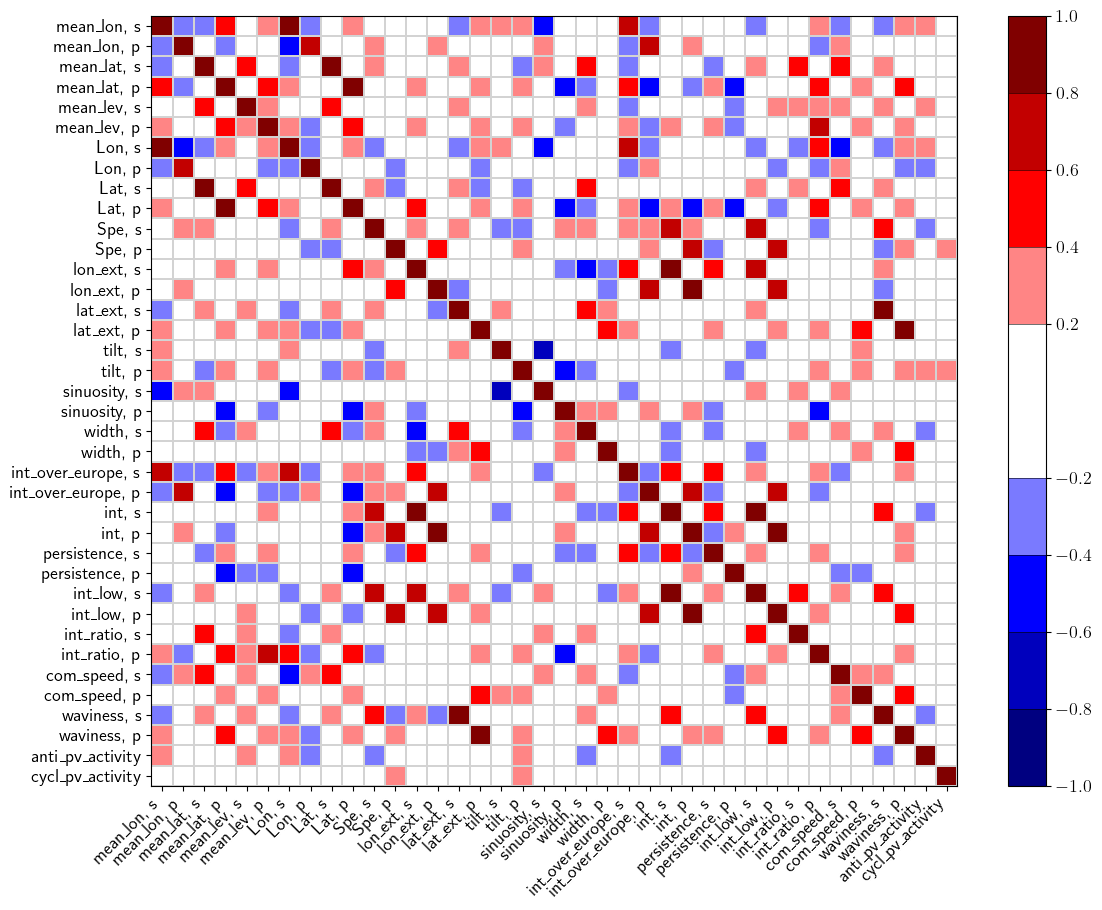

In [55]:
to_concat = []
ticks = []
freq = "1YE"
this_pads = props_as_ds_late.resample(time=freq).mean()
valids = this_pads["mean_lon"]
valids = (
    ~valids.sel(jet="polar").isnull() & ~valids.sel(jet="subtropical").isnull()
).values
for varname, da in this_pads.items():
    if varname not in [
        "anti_pv_activity",
        "cycl_pv_activity",
        "overlap",
        "vert_dist",
        "n_jets",
        "nao",
        "double_jet_index",
    ]:
        for jet in da.jet.values:
            to_concat.append(da.sel(jet=jet).fillna(DEFAULT_VALUES.get(varname, 0)).values[valids])
            ticks.append(f"{varname}, {jet[0]}")
    else:
        to_concat.append(np.roll(da.fillna(0).values[valids], 0))
        ticks.append(varname)
fig, ax = plt.subplots(figsize=(13, 10))
im = plt.pcolormesh(np.corrcoef(np.stack(to_concat)), cmap=cmap, norm=norm, lw=0.01, edgecolors="lightgrey")
plt.colorbar(im, spacing="proportional", drawedges=True)
ax.invert_yaxis()
ax.set_yticks(np.arange(0.5, len(ticks) + 0.5), ticks)
_ = ax.set_xticks(np.arange(0.5, len(ticks) + 0.5), ticks, rotation=45, ha="right")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_full_{freq}.png", **SAVE_KWARGS)

# Seasonal variability ?

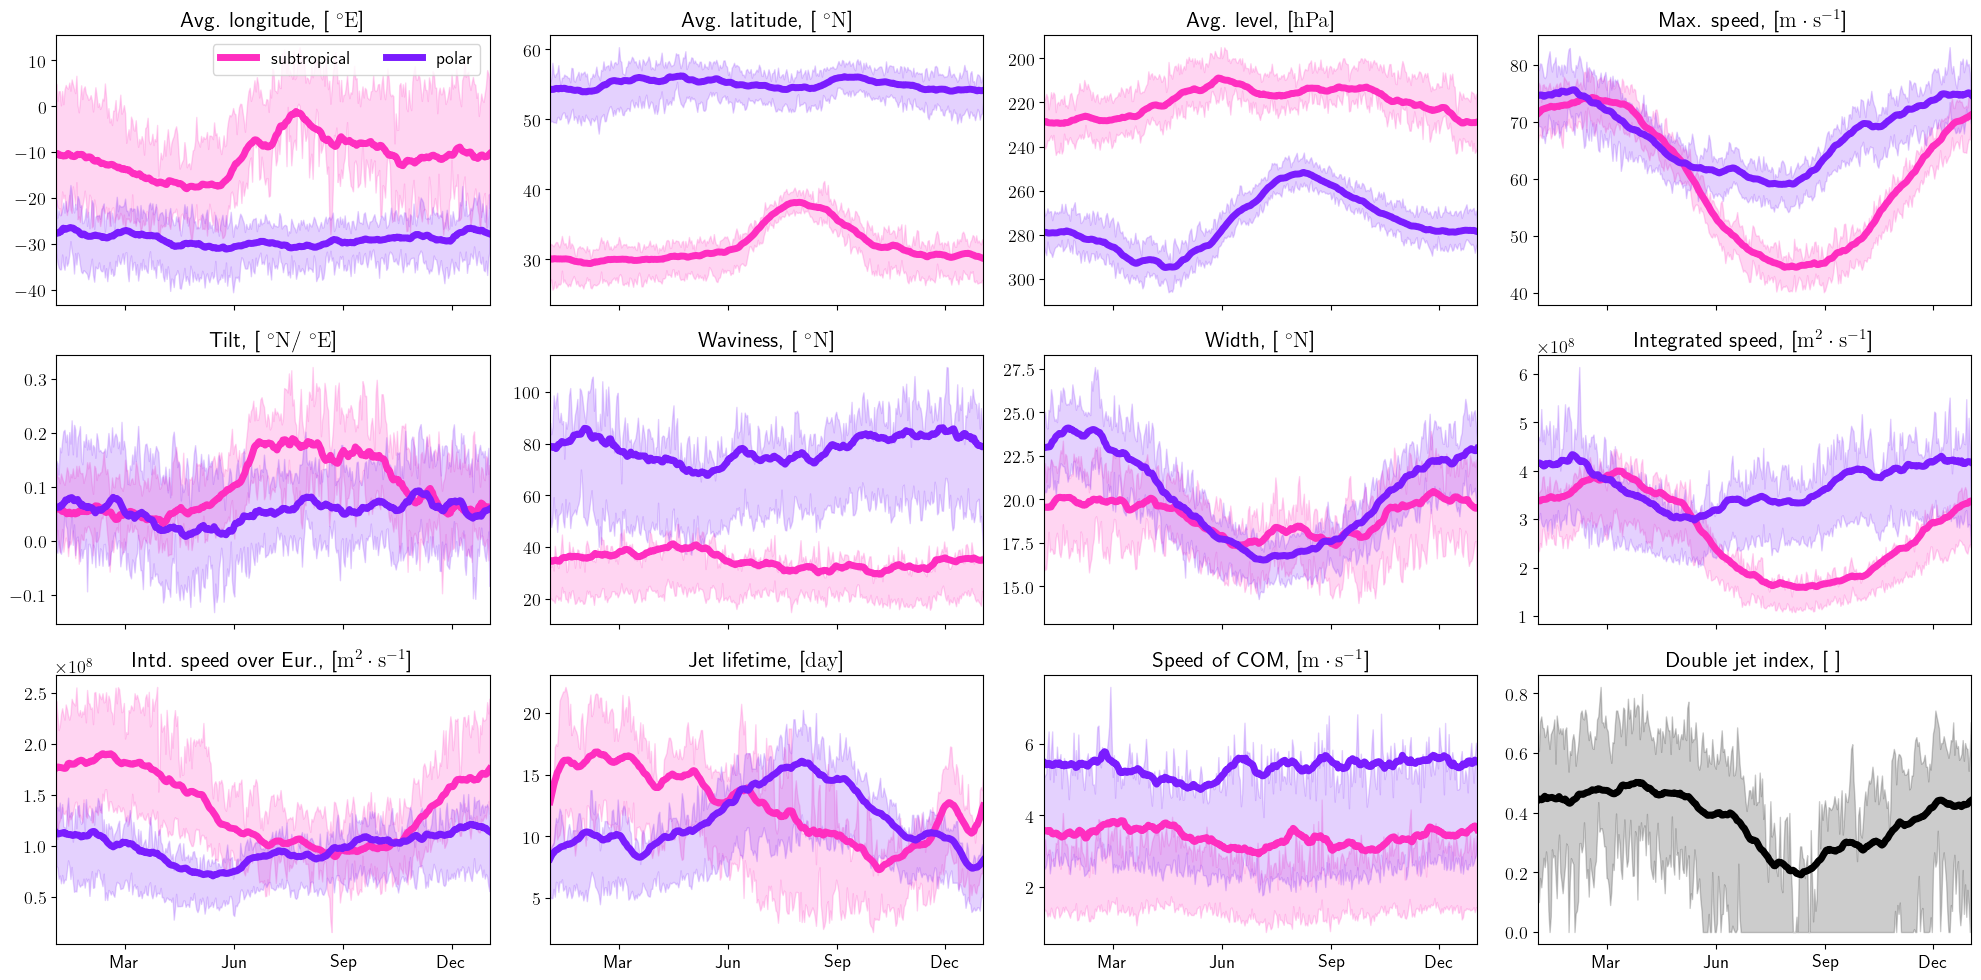

In [5]:
from matplotlib.dates import DateFormatter, MonthLocator

fig, axes = plt.subplots(3, 4, figsize=(20, 10), tight_layout=True, sharex="all")
winsize = 15
halfwinsize = int(np.ceil(winsize / 2))
jets = props_as_ds.jet.values
for varname, ax in zip(data_vars, axes.ravel()):
    gb = props_as_ds[varname].groupby("time.dayofyear")
    x = list(gb.groups.keys())
    x = DATERANGE[x]
    ys = gb.mean()
    ys = ys.pad({"dayofyear": halfwinsize}, mode="wrap")
    ys = ys.rolling(dayofyear=15, center=True, min_periods=1).mean()
    ys = ys.isel({"dayofyear": slice(halfwinsize, -halfwinsize)}).values
    qs = gb.quantile(q=[0.33, 0.66]).values
    if ys.ndim == 1:
        ax.fill_between(x, qs[:, 0], qs[:, 1], color="black", alpha=0.2)
        ax.plot(x, ys, lw=5, color="black")
    else:
        for i in range(2):
            ax.fill_between(x, qs[:, i, 0], qs[:, i, 1], color=COLORS[2 - i], alpha=0.2)
            ax.plot(x, ys[:, i], lw=5, color=COLORS[2 - i], label=jets[i])
    ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]")
    ax.xaxis.set_major_locator(MonthLocator(range(0, 13, 3)))
    ax.xaxis.set_major_formatter(DateFormatter("%b"))
    ax.set_xlim(min(x), max(x))
    if varname == "mean_lev":
        ax.invert_yaxis()
axes.ravel()[0].legend(ncol=2)
plt.savefig(f"{FIGURES}/jet_props_misc/jet_props_seasonal.png", **SAVE_KWARGS)

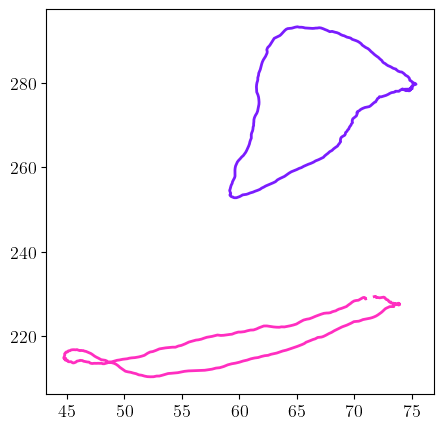

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
winsize = 15
halfwinsize = int(np.ceil(winsize / 2))
jets = props_as_ds.jet.values
ouais = []
for varname in ["Spe", "mean_lev"]:
    gb = props_as_ds[varname].groupby("time.dayofyear")
    ys = gb.mean()
    ys = ys.pad({"dayofyear": halfwinsize}, mode="wrap")
    ys = ys.rolling(dayofyear=31, center=True, min_periods=1).mean()
    ys = ys.isel({"dayofyear": slice(halfwinsize, -halfwinsize)}).values
    ouais.append(ys)
ax.plot(ouais[0][:, 0], ouais[1][:, 0], color=COLORS[2], lw=2)
ax.plot(ouais[0][:, 1], ouais[1][:, 1], color=COLORS[1], lw=2)

# Dayofyear trend

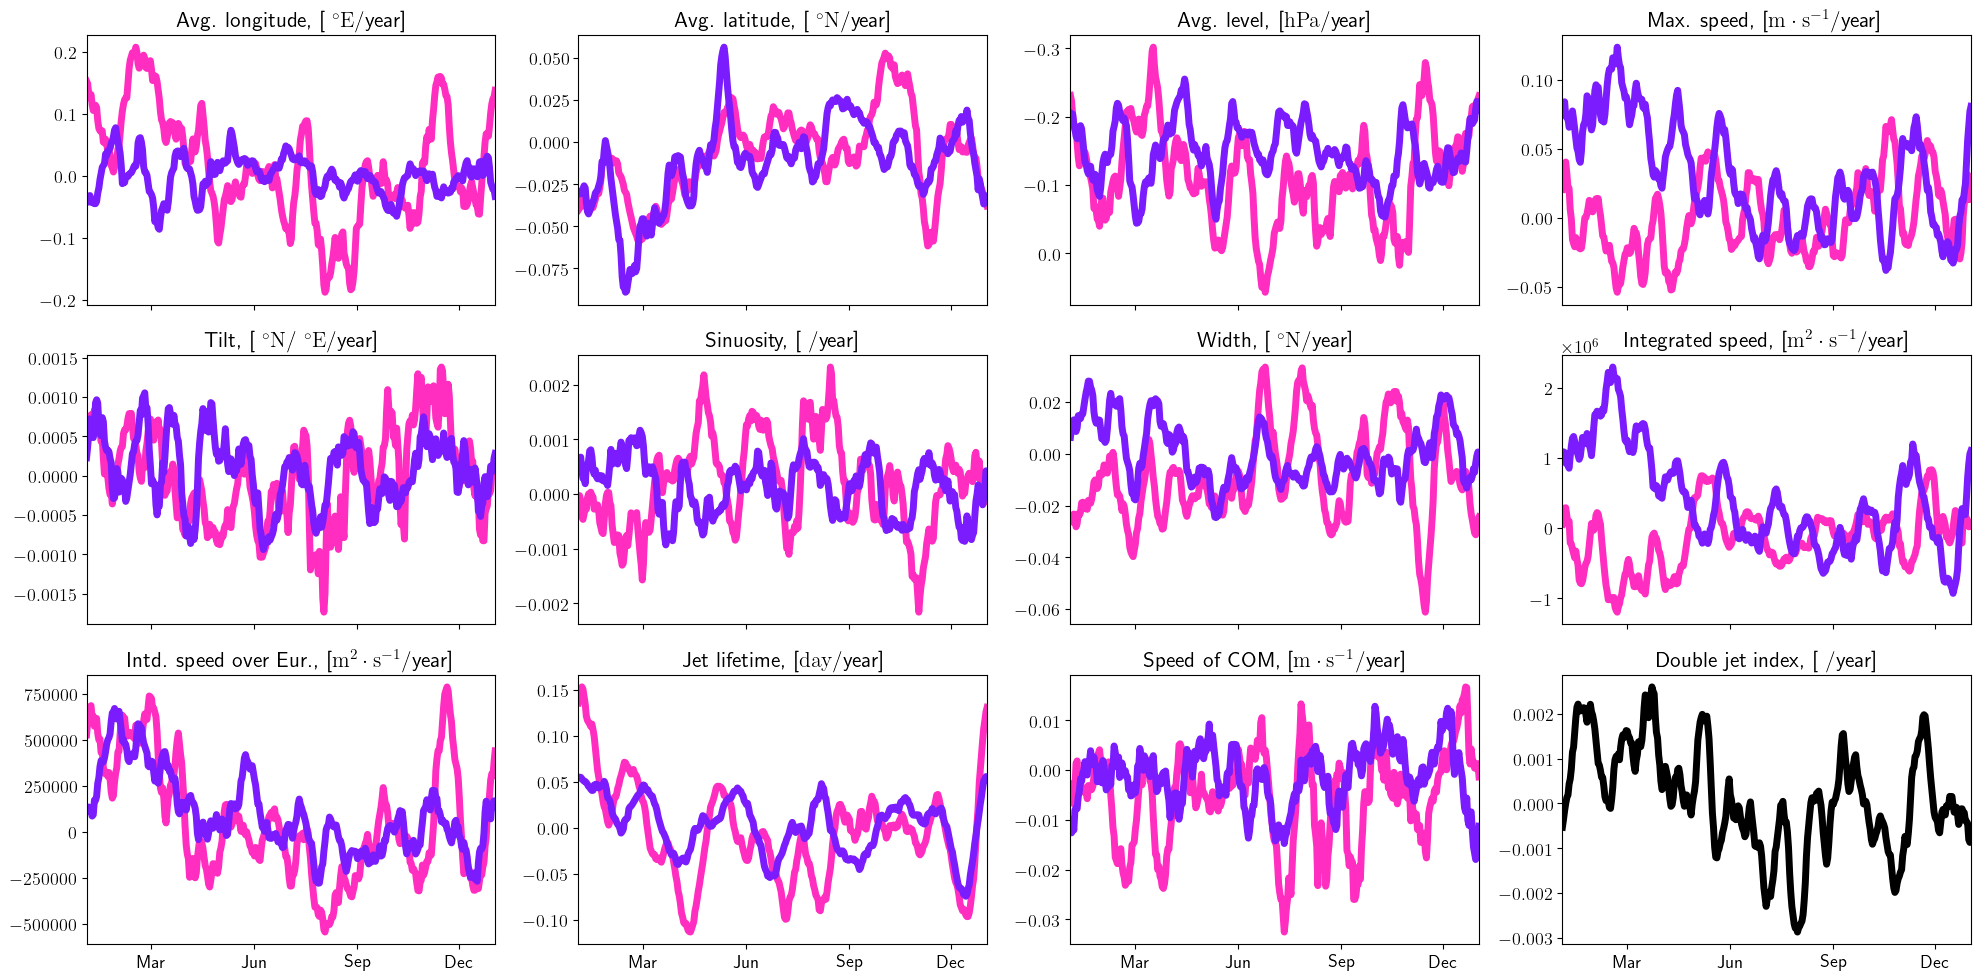

In [55]:
def get_trend(da):
    return da.polyfit("time", 1)["polyfit_coefficients"].sel(degree=1) * 3.1557e16

winsize = 15
halfwinsize = int(np.ceil(winsize / 2))
fig, axes = plt.subplots(3, 4, figsize=(20, 10), tight_layout=True, sharex="all")
for varname, ax in zip(data_vars, axes.ravel()):
    gb = props_as_ds[varname].resample(time="1D").mean().groupby("time.dayofyear")
    x = list(gb.groups.keys())
    x = DATERANGE[x]
    ys = gb.map(get_trend) 

    ys = ys.pad({"dayofyear": halfwinsize}, mode="wrap")
    ys = ys.rolling(dayofyear=15, center=True, min_periods=1).mean()
    ys = ys.isel({"dayofyear": slice(halfwinsize, -halfwinsize)})
    if ys.ndim == 1:
        ax.plot(x, ys, lw=5, color="black")
    else:
        for i in range(2):
            ax.plot(x, ys[:, i], lw=5, color=COLORS[2 - i])
    ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}/year]")
    ax.xaxis.set_major_locator(MonthLocator(range(0, 13, 3)))
    ax.xaxis.set_major_formatter(DateFormatter("%b"))
    ax.set_xlim(min(x), max(x))
    if varname == "mean_lev":
        ax.invert_yaxis()
plt.savefig(f"{FIGURES}/jet_props_misc/dayofyear_trends.png", **SAVE_KWARGS)

# Is polar

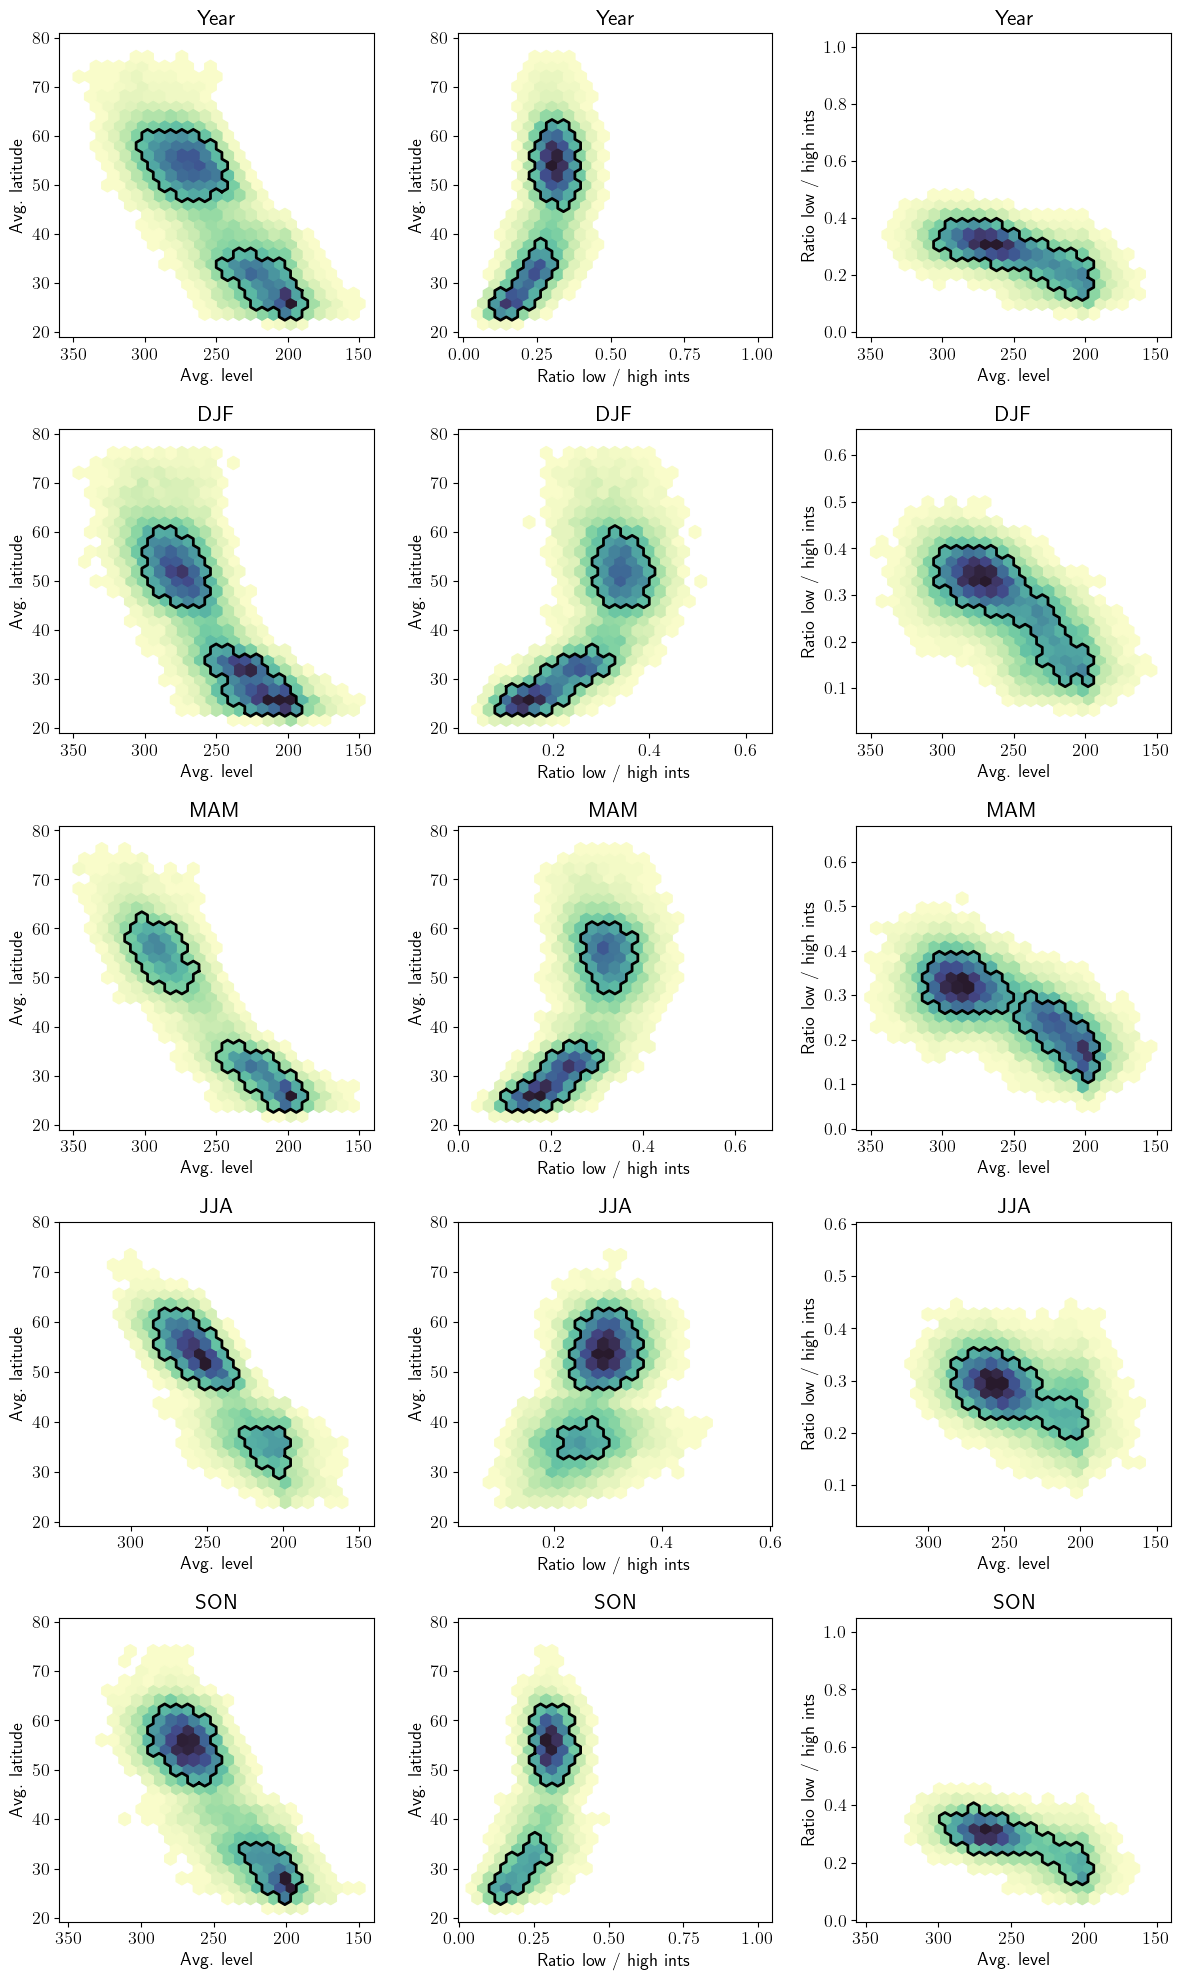

In [59]:
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely import set_precision

fig, axes = plt.subplots(5, 3, figsize=(12, 20), tight_layout=True)
for season, axs in zip([None, "DJF", "MAM", "JJA", "SON"], axes):
    feature_names = ["mean_lat", "mean_lev", "int_ratio"]
    X, _ = extract_features(props_as_ds, feature_names, season)
    for feature_ind, ax in zip(((1, 0), (2, 0), (1, 2)), axs):
        cmap = make_transparent(colormaps.deep, nlev=100, n_transparent=1)
        im = ax.hexbin(*X[:, feature_ind].T, gridsize=25, cmap=cmap)
        try:
            ax.set_xlabel(PRETTIER_VARNAME[feature_names[feature_ind[0]]])
            ax.set_ylabel(PRETTIER_VARNAME[feature_names[feature_ind[1]]])
        except KeyError:
            ax.set_xlabel(feature_names[feature_ind[0]])
            ax.set_ylabel(feature_names[feature_ind[1]])
        offsets = im.get_offsets()
        counts = im.get_array()
        which = counts > 2.0 * counts.std()
        hex_poly = im.get_paths()[0].vertices
        hex_array = []
        for offs in offsets[which]:
            hex_array.append(set_precision(Polygon(hex_poly + offs[None, :]), 0.0001))
        polygon = unary_union(hex_array)
        try:
            ax.plot(*polygon.boundary.xy, color="black", lw=2)
        except NotImplementedError:
            for boundary in polygon.boundary.geoms:
                ax.plot(*boundary.xy, color="black", lw=2)
        if feature_names[feature_ind[0]] == "mean_lev":
            ax.invert_xaxis()
        if feature_names[feature_ind[1]] == "mean_lev":
            ax.invert_yaxis()
        ax.set_title(season if season is not None else "Year")
plt.savefig(f"{FIGURES}/jet_props_misc/is_polar.png", **SAVE_KWARGS)

Elapsed time: 1.6783 seconds
Elapsed time: 0.4435 seconds
Elapsed time: 0.4656 seconds
Elapsed time: 0.3951 seconds
Elapsed time: 0.4037 seconds


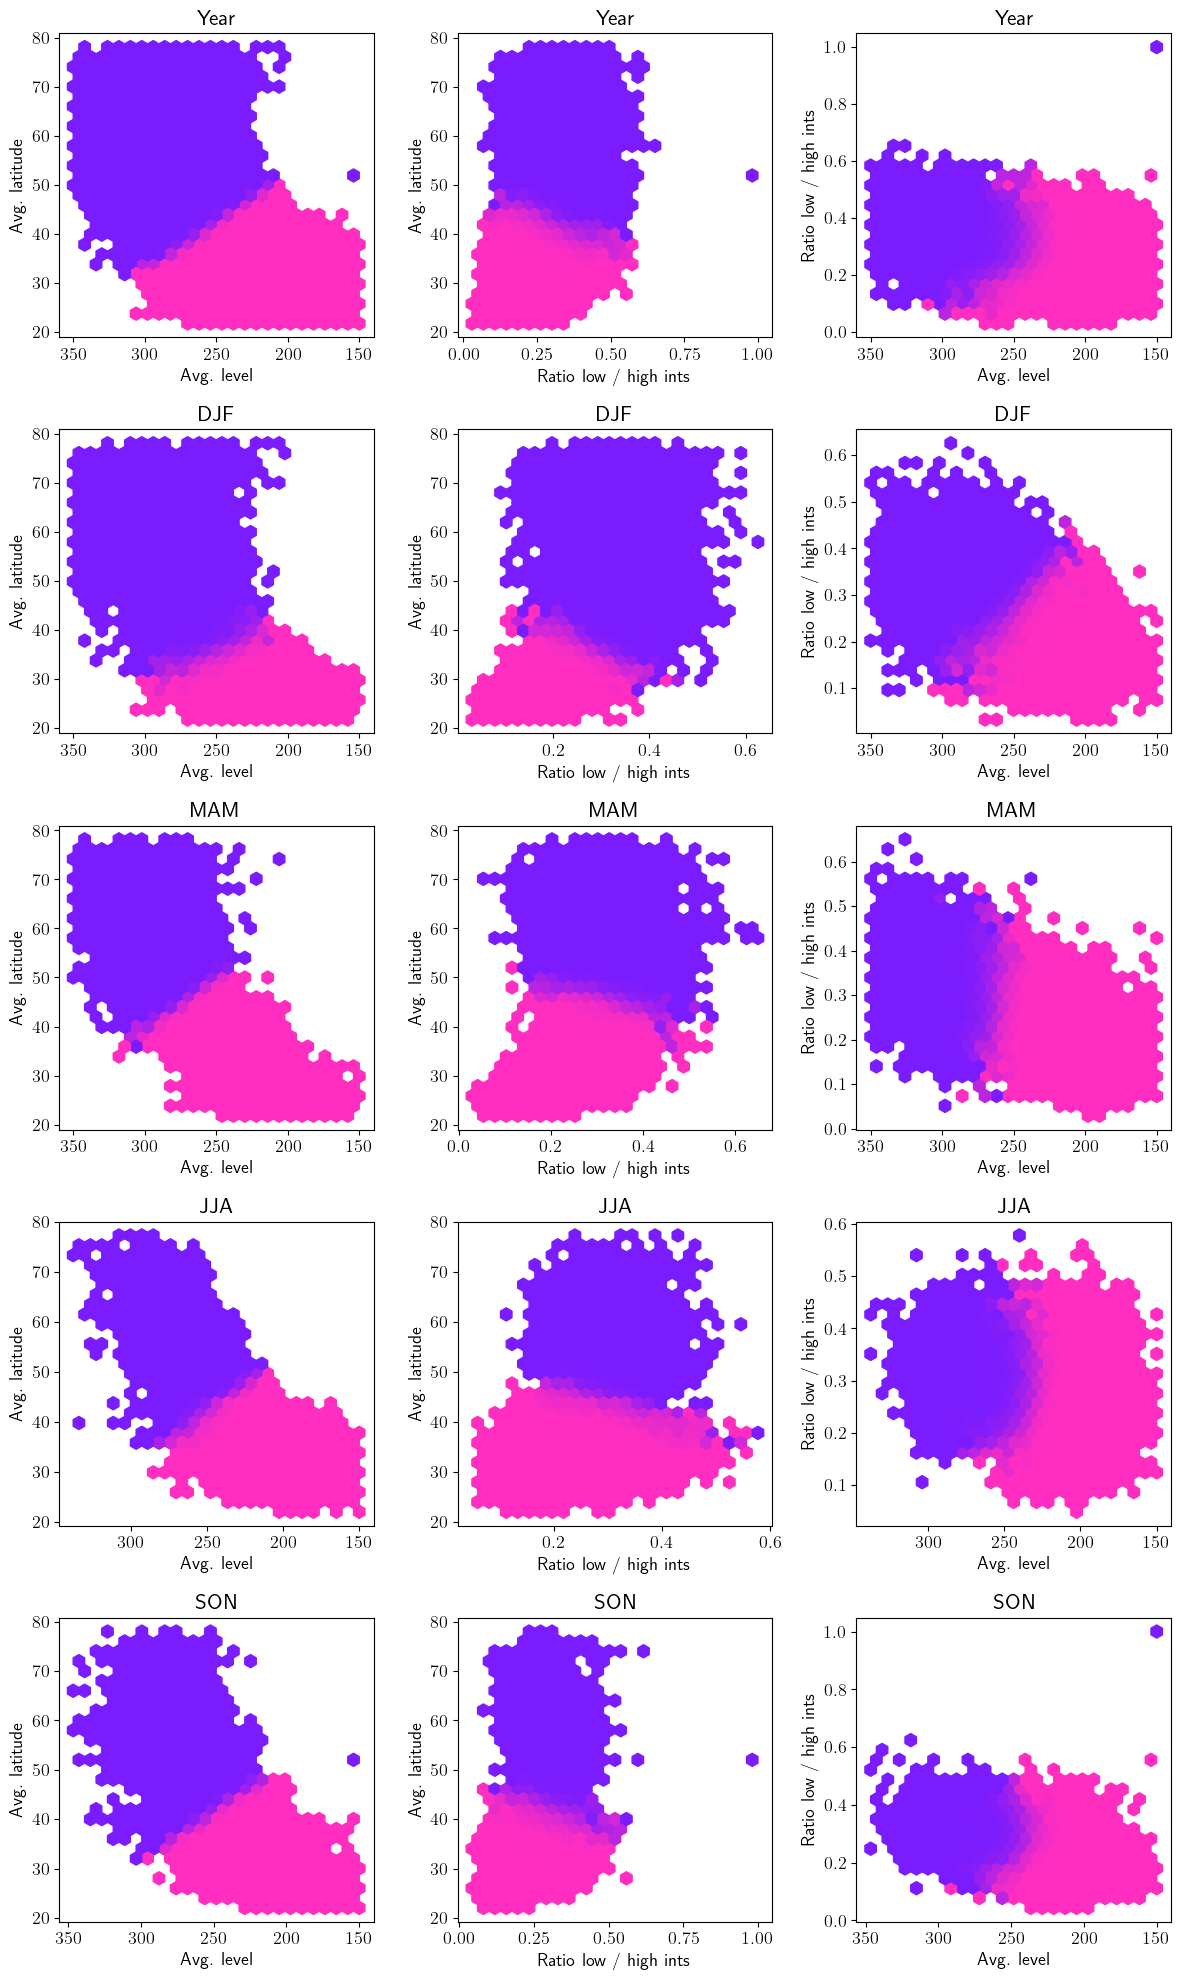

In [70]:
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import Birch
PINKPURPLE = LinearSegmentedColormap.from_list("pinkpurple", [COLORS[2], COLORS[1]])

def to_zero_one(X):
    Xmin = X.min(axis=0)
    Xmax = X.max(axis=0)
    
    return (X - Xmin[None, :]) / (Xmax - Xmin)[None, :], Xmin, Xmax


def revert_zero_one(X, Xmin, Xmax):
    return Xmin[None, :] + (Xmax - Xmin)[None, :] * X

fig, axes = plt.subplots(5, 3, figsize=(12, 20), tight_layout=True)
for season, axs in zip([None, "DJF", "MAM", "JJA", "SON"], axes):
    feature_names = ["mean_lat", "mean_lev", "int_ratio"]
    X, _ = extract_features(props_as_ds, feature_names, season)
    X, Xmin, Xmax = to_zero_one(X)
    with Timer():
        labels = Birch(threshold=0.2, n_clusters=2).fit(X).labels_
    X = revert_zero_one(X, Xmin, Xmax)
    ml1 = X[labels.astype(bool), 0].mean()
    ml2 = X[(1 - labels).astype(bool), 0].mean()
    if ml2 > ml1:
        labels = 1 - labels
    for feature_ind, ax in zip(((1, 0), (2, 0), (1, 2)), axs):
        cmap = PINKPURPLE
        im = ax.hexbin(*X[:, feature_ind].T, gridsize=25, cmap=cmap, C=labels)
        try:
            ax.set_xlabel(PRETTIER_VARNAME[feature_names[feature_ind[0]]])
            ax.set_ylabel(PRETTIER_VARNAME[feature_names[feature_ind[1]]])
        except KeyError:
            ax.set_xlabel(feature_names[feature_ind[0]])
            ax.set_ylabel(feature_names[feature_ind[1]])
        ax.set_title(season if season is not None else "Year")
        if feature_names[feature_ind[0]] == "mean_lev":
            ax.invert_xaxis()
        if feature_names[feature_ind[1]] == "mean_lev":
            ax.invert_yaxis()
plt.savefig(f"{FIGURES}/jet_props_misc/is_polar_birch.png", **SAVE_KWARGS)

# Demo: double anim

In [ ]:
r1 = len(da_s.lon) / len(da_s.lat)
r2 = 1
height = 4
wspace = 0.04
cbar_size = 0.05
fig = plt.figure(
    figsize=(height * (r1 + r2 + 2 * cbar_size + 3 * wspace), height), dpi=90
)
gs = GridSpec(
    1,
    5,
    width_ratios=(r1, cbar_size, 4 * wspace, r2, cbar_size),
    wspace=0.02,
    figure=fig,
)

fig.add_subplot(gs[2], visible=False)
ax_contourf = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax_contourf.set_extent(
    exp_s.region,
    crs=ccrs.PlateCarree(),
)
ax_contourf.add_feature(COASTLINE)
cs = ax_contourf.contourf(
    da_s.lon.values, da_s.lat.values, da_s[tsteps[0]].values, **kwargs_contourf
)
cax = fig.add_subplot(gs[1])
fig.colorbar(cs, cax=cax)

ax_trajectory = fig.add_subplot(gs[3])
# ax_trajectory.plot([1, 2])
kwargs_trajectory = dict(
    cmap=mpl.colormaps["gray_r"], norm=Normalize(np.amin(thesepops), np.amax(thesepops))
)
xlims = [
    np.amin(coords[~outermask][:, 0]) - 0.8,
    np.amax(coords[~outermask][:, 0]) + 0.8,
]
ylims = [np.amin(coords[~outermask][:, 1]) - 1, np.amax(coords[~outermask][:, 1]) + 1]
fig, ax_trajectory = splots.plot_map(
    coords,
    populations,
    "hexagons",
    draw_cbar=False,
    show=False,
    edgecolors="black",
    cmap="Greys",
    alphas=alphas,
    linewidths=0,
    fig=fig,
    ax=ax_trajectory,
)
cax = fig.add_axes([0.67, 0.84, 0.06, 0.04])
im = ScalarMappable(**kwargs_trajectory)
fig.colorbar(im, cax=cax, orientation="horizontal", ticks=[])
cax.text(-5, 0.35, "0", ha="center", va="center")
max_pop = np.amax(populations)
cax.text(max_pop + 9, 0.35, f"{max_pop}", ha="center", va="center")

lc = LineCollection(segments, cmap="magma", norm=norm)
lc.set_array(np.repeat(np.arange(len(traj) - 1), repeats=reps))
lc.set_linewidth(3)
lc = ax_trajectory.add_collection(lc)
cax = fig.add_subplot(gs[4])
cbar = fig.colorbar(lc, label=f"Days of summer {YEARSPL[yearidx]}", cax=cax)
list_of_days = np.asarray([0, 14 * 4, 30 * 4, 44 * 4, 61 * 4, 75 * 4, 91 * 4 + 3])

pretty_list_of_days = (
    da.time[yearidx * 92 * 4 + list_of_days].dt.strftime("%b %d").values
)
cbar.ax.set_yticks(list_of_days, labels=pretty_list_of_days)
cbar.ax.invert_yaxis()
ax_trajectory.set_xlim(xlims)
ax_trajectory.set_ylim(ylims)

jets = all_jets[tsteps[0]]
lines = []
for j in range(3):
    try:
        jet = jets[j]
        x, y, s = jet.T
        p = np.polyfit(x, y, w=s, deg=3, full=False)
        p = np.poly1d(p)
        newy = p(x)
    except IndexError:
        x, newy, s = [], [], []

    lines.append(ax_contourf.plot(x, newy, color="dimgray", lw=4)[0])


def animate(i):
    global cs
    global lines
    global lc
    for c in cs.collections:
        c.remove()
    cs = ax_contourf.contourf(
        da_s.lon.values, da_s.lat.values, da_s[tsteps[i]].values, **kwargs_contourf
    )
    jets = all_jets[tsteps[i]]
    for j in range(3):
        try:
            jet = jets[j]
            x, y, s = jet.T
        except IndexError:
            x, y, s = [], [], []
        lines[j].set_data(x, y)
    if i > 1:
        to_be_set_visible = np.sum(reps[:i])
        lws = np.zeros(len(segments))
        lws[:to_be_set_visible] = 4
        lc.set_lw(lws)
    else:
        lc.set_lw(0.0)
    fig.suptitle(titles[i])
    return cs, lines, lc


ani = FuncAnimation(fig, animate, frames=np.arange(len(tsteps)))
ani.save("Figures/double_anim.gif", dpi=200, fps=5)